In [2]:
#look at conditions
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import combinations
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none',
                 
}
mpl.rcParams.update(new_rc_params)

In [3]:
def calculate_enrichment(trp_col_with_na, his_col_with_na, trp_count=0, his_count=0):
    if trp_count == 0 and his_count == 0:
        trp_count = trp_col_with_na.fillna(0).values.sum()
        his_count = his_col_with_na.fillna(0).values.sum()
        norm_coefficient = trp_count / his_count
        return norm_coefficient * his_col_with_na.fillna(his_col_with_na.min()) / trp_col_with_na.fillna(trp_col_with_na.min())
    else:
        norm_coefficient = trp_count / his_count
        return norm_coefficient * his_col_with_na.fillna(his_col_with_na.min()) / trp_col_with_na.fillna(trp_col_with_na.min())

def split_by_orientation(df, proteins, col_extract, keep_homodimers=True):
    # for a col, reorder to 2 rows for each PPI

    # all combos of 2
    combos = list(combinations(proteins, 2))
    if keep_homodimers:
        combos = combos + [(x, x) for x in proteins]
    # df of all combos of 2
    ppis = pd.DataFrame({'DBD_fast': [c[0] for c in combos], 'AD_fast': [c[1] for c in combos]})

    ppis['or_1_ppi'] = 'DBD:' + ppis['DBD_fast'] + ':AD:' + ppis['AD_fast']
    ppis['or_2_ppi'] = 'DBD:' + ppis['AD_fast'] + ':AD:' + ppis['DBD_fast']

    ppis = ppis.merge(df, left_on='or_1_ppi', right_on='PPI')
    ppis = ppis.merge(df, left_on='or_2_ppi', right_on='PPI', suffixes=('_DBDAD', '_ADDBD'))
    ppis['PPI'] = ppis.apply(lambda row: make_ppi(row['DBD_fast'], row['AD_fast']), axis=1)
    return ppis[['PPI', col_extract + '_DBDAD', col_extract + '_ADDBD']]


def make_single_col_from_df(df, binders_list):
    final_counts = []
    final_binder_pairs = []
    for b in binders_list:
        for b2 in binders_list:
            if b2 in df:
                val_row = df[df.Binder1 == b][b2].to_list()
                if len(val_row) > 0:
                    final_counts.append(val_row[0])
                    final_binder_pairs.append("DBD:" + b + ':AD:' + b2)
    return pd.DataFrame({'PPI': final_binder_pairs, 'count': final_counts})

def make_ppi(one, two):
    """
    Makes a PPI name by sorting protein names and joining
    :param one: One input protein name (str)
    :param two: Other input protein name (str)
    :return: Final PPI name (str), formatted as P1:P2 where P1 is before P2 when sorted
    """
    ppi = [one, two]
    ppi.sort()
    return ':'.join(ppi)

In [4]:
#opening the different trp time tables 
jerala_proteins = ['Jerala_P1', 'Jerala_P2', 'Jerala_P3', 'Jerala_P4',
 'Jerala_P5','Jerala_P6','Jerala_P7','Jerala_P8','Jerala_P9',
 'Jerala_P10','Jerala_P11','Jerala_P12']

hour_24 = make_single_col_from_df(pd.read_csv('../data/final_mp3seq_method/l61/L61_TRP_24h_table.csv'), jerala_proteins)                  
hour_44 = make_single_col_from_df(pd.read_csv('../data/final_mp3seq_method/l61/L61_TRP_44h_table.csv'), jerala_proteins)    
hour_60 = make_single_col_from_df(pd.read_csv('../data/final_mp3seq_method/l61/L61_TRP_60h_table.csv'), jerala_proteins)    

#rename cols
hour_24.rename(columns = {'count': 'trp24'}, inplace = True)
hour_44.rename(columns = {'count': 'trp44'}, inplace = True)
hour_60.rename(columns = {'count': 'trp60'}, inplace = True)
#merge
trp_diff_times = hour_24.merge(hour_44, how = 'outer', on = 'PPI')
trp_diff_times = trp_diff_times.merge(hour_60, how = 'outer', on = 'PPI')

In [5]:
target_orientations = []
target_ppis = []
for i in range(1,13,2):
    target_orientations.append('DBD:Jerala_P' + str(i) + ':AD:Jerala_P' + str(i+1))
    target_orientations.append('DBD:Jerala_P' + str(i+1) + ':AD:Jerala_P' + str(i))
    ppi_label = ['Jerala_P' + str(i) , 'Jerala_P' + str(i+1) ]
    ppi_label.sort()
    target_ppis.append(':'.join(ppi_label))

trp_diff_times['on_target'] = trp_diff_times.PPI.apply(lambda x: x in target_orientations)



In [6]:
#adjust by read count fractions 

trp_diff_times['trp_l61_size_norm_24'] = trp_diff_times['trp24']/trp_diff_times['trp24'].sum()
trp_diff_times['trp_l61_size_norm_44'] = trp_diff_times['trp44']/trp_diff_times['trp44'].sum()
trp_diff_times['trp_l61_size_norm_60'] = trp_diff_times['trp60']/trp_diff_times['trp60'].sum()

In [19]:
trp_diff_times[['trp44', 'trp60']].dropna()

,trp44,trp60
0,14,20
1,1356,1237
2,3068,3430
3,1644,1846
4,2895,3245
...,...,...
139,3097,3073
140,2249,2325
141,3112,3280
142,1503,1364


[Text(0.0, 0, '0.000'), Text(0.002, 0, '0.002'), Text(0.004, 0, '0.004'), Text(0.006, 0, '0.006'), Text(0.008, 0, '0.008'), Text(0.01, 0, '0.010'), Text(0.012, 0, '0.012'), Text(0.014, 0, '0.014'), Text(0.016, 0, '0.016'), Text(0.018000000000000002, 0, '0.018')]
[Text(0, 0.0, '0.0000'), Text(0, 0.0025, '0.0025'), Text(0, 0.005, '0.0050'), Text(0, 0.0075, '0.0075'), Text(0, 0.01, '0.0100'), Text(0, 0.0125, '0.0125'), Text(0, 0.015, '0.0150'), Text(0, 0.0175, '0.0175'), Text(0, 0.02, '0.0200'), Text(0, 0.0225, '0.0225')]


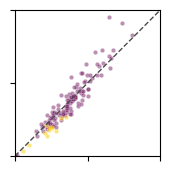

trp_l61_size_norm_44
0.9010933230947544
0.9436444381945563
------------------------
[Text(0.0, 0, '0.000'), Text(0.002, 0, '0.002'), Text(0.004, 0, '0.004'), Text(0.006, 0, '0.006'), Text(0.008, 0, '0.008'), Text(0.01, 0, '0.010'), Text(0.012, 0, '0.012'), Text(0.014, 0, '0.014'), Text(0.016, 0, '0.016'), Text(0.018000000000000002, 0, '0.018')]
[Text(0, 0.0, '0.0000'), Text(0, 0.0025, '0.0025'), Text(0, 0.005, '0.0050'), Text(0, 0.0075, '0.0075'), Text(0, 0.01, '0.0100'), Text(0, 0.0125, '0.0125'), Text(0, 0.015, '0.0150'), Text(0, 0.0175, '0.0175'), Text(0, 0.02, '0.0200'), Text(0, 0.0225, '0.0225')]


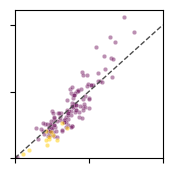

trp_l61_size_norm_60
0.8362521318927886
0.9044232085180236
------------------------


In [11]:
#ashr vs others 

on_targets = "#ffcc00ff"
off_targets = "#782167ff"

on_target_df = trp_diff_times[trp_diff_times.on_target == True]
off_target_df = trp_diff_times[trp_diff_times.on_target == False]

for other in ['trp_l61_size_norm_44', 'trp_l61_size_norm_60']:#', 'log2_enrich_l62', 'log2_enrich_l67', 'avg_log_no_adj_counts']:

    fig, ax = plt.subplots()
    sns.scatterplot(data = off_target_df, x = 'trp_l61_size_norm_24', y = other, color = off_targets, alpha = 0.5,s = 10)
    sns.scatterplot(data = on_target_df, x = 'trp_l61_size_norm_24', y = other, color = on_targets, alpha = 0.5,s = 10)
    #sns.scatterplot(on_target_df['trp_l61_size_norm_24'], on_target_df[other],color = on_targets,s = 10, alpha = 0.75)#, alpha = 0.75))#, alpha = 0.75)
    plt.tight_layout()
    ax.set_xlim(left = 0)
    ax.set_ylim(bottom = 0)
    locsx, labels = plt.xticks()
    print (labels)
    plt.xticks([0,0.01,0.02], [])
    locsy, labels = plt.yticks()
    print (labels)
    plt.yticks([0,0.01,0.02], [])
    plt.xlabel("")
    plt.ylabel("")
    #resize 
    fig.set_size_inches(1.75, 1.75)
    ax.plot([0,ax.get_xlim()[1]],[0,ax.get_xlim()[1]], ls="--", c=".3", linewidth = 1)
    #ax.plot([1/144,1/144],[0,ax.get_ylim()[1]], ls="--", c="red", linewidth = 1)
    #ax.plot([0,ax.get_ylim()[1]], [1/144,1/144], ls="--", c="red", linewidth = 1)
    plt.savefig( other + 'vs_24h_norm.png', dpi = 300)
    
    plt.show()

    print (other)
    print (stats.pearsonr(trp_diff_times['trp_l61_size_norm_24'],
                             trp_diff_times[other])[0]**2)
    print (stats.spearmanr(trp_diff_times['trp_l61_size_norm_24'],
                             trp_diff_times[other])[0])
    print ('------------------------')





/home/lafleur1/anaconda3/envs/dimsum/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/lafleur1/anaconda3/envs/dimsum/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(-0.0025, 0, '−0.0025'), Text(0.0, 0, '0.0000'), Text(0.0025, 0, '0.0025'), Text(0.004999999999999999, 0, '0.0050'), Text(0.0075, 0, '0.0075'), Text(0.01, 0, '0.0100'), Text(0.012499999999999999, 0, '0.0125'), Text(0.015000000000000001, 0, '0.0150'), Text(0.0175, 0, '0.0175'), Text(0.02, 0, '0.0200')]
[Text(0, -0.005, '−0.005'), Text(0, 0.0, '0.000'), Text(0, 0.005, '0.005'), Text(0, 0.009999999999999998, '0.010'), Text(0, 0.015, '0.015'), Text(0, 0.02, '0.020'), Text(0, 0.024999999999999998, '0.025'), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]


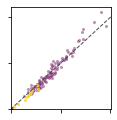

trp_l61_size_norm_60
0.9653382944337693
0.9788088719242677
------------------------


In [10]:
#ashr vs others 

on_targets = "#ffcc00ff"
off_targets = "#782167ff"

on_target_df = trp_diff_times[trp_diff_times.on_target == True]
off_target_df = trp_diff_times[trp_diff_times.on_target == False]

for other in [ 'trp_l61_size_norm_60']:#', 'log2_enrich_l62', 'log2_enrich_l67', 'avg_log_no_adj_counts']:

    fig, ax = plt.subplots()
    sns.scatterplot(off_target_df['trp_l61_size_norm_44'], off_target_df[other],color = off_targets, alpha = 0.5,s = 10)
    sns.scatterplot(on_target_df['trp_l61_size_norm_44'], on_target_df[other],color = on_targets,s = 10, alpha = 0.75)#, alpha = 0.75))#, alpha = 0.75)#, alpha = 0.75)
    #plt.xlim(left=0)
    plt.tight_layout()
    ax.set_xlim(left = 0)
    ax.set_ylim(bottom = 0)
    locsx, labels = plt.xticks()
    print (labels)
    plt.xticks([0,0.01,0.02], [])
    locsy, labels = plt.yticks()
    print (labels)
    plt.yticks([0,0.01,0.02], [])
    plt.xlabel("")
    plt.ylabel("")
    #resize 
    ax.plot([0,ax.get_xlim()[1]],[0,ax.get_xlim()[1]], ls="--", c=".3", linewidth = 1)
    #ax.plot([1/144,1/144],[0,ax.get_ylim()[1]], ls="--", c="red", linewidth = 1)
    #ax.plot([0,ax.get_ylim()[1]], [1/144,1/144], ls="--", c="red", linewidth = 1)
    fig.set_size_inches(1.75, 1.75)
    plt.savefig('./figures/' + other + 'vs_44h_norm.png', dpi = 300)
    
    plt.show()

    print (other)
    print (stats.pearsonr(trp_diff_times['trp_l61_size_norm_44'],
                             trp_diff_times[other])[0]**2)
    print (stats.spearmanr(trp_diff_times['trp_l61_size_norm_44'],
                             trp_diff_times[other])[0])
    print ('------------------------')





In [20]:

trp_diff_times = pd.read_csv("./merged_files/l61_comp_3at.csv")
trp_diff_times = trp_diff_times.rename(columns = {'Unnamed: 0': 'PPI'})

target_orientations = []
target_ppis = []
for i in range(1,13,2):
    #print (i, i + 1)
    target_orientations.append('DBD:Jerala_P' + str(i) + ':AD:Jerala_P' + str(i+1))
    target_orientations.append('DBD:Jerala_P' + str(i+1) + ':AD:Jerala_P' + str(i))
    ppi_label = ['Jerala_P' + str(i) , 'Jerala_P' + str(i+1) ]
    ppi_label.sort()
    target_ppis.append(':'.join(ppi_label))

    
## compare with real values now
true_vals = pd.read_csv('local_copy/bft/twist/l61/NICP_invivo-data.csv')
#DBD:Jerala_P1:AD:Jerala_P1
#true_vals['on_target'] = true_vals.apply(lambda row: abs(row['Peptide1'] - row['Peptide2'])  == 1, axis =1 ) 
true_vals['str_1'] = true_vals['Peptide1'].apply(lambda x: 'Jerala_P' + str(x))
true_vals['str_2'] = true_vals['Peptide2'].apply(lambda x: 'Jerala_P' + str(x))
true_vals['PPI'] = 'DBD:' + true_vals['str_2'] + ':AD:' + true_vals['str_1'] #[df.PPI == 'DBD:' + dbd + ':AD:' + ad]
true_vals['on_target'] = true_vals.PPI.apply(lambda x: x in target_orientations)
print (true_vals.on_target.value_counts())
true_vals['log_fa'] = np.log(true_vals['Fold activation'])
trp_diff_times = trp_diff_times.merge(true_vals, on = 'PPI')
#trp_diff_times[['PPI'] + ashr_cols + list(true_vals.columns)].sort_values(by = 'Fold activation')
from scipy import stats
print (trp_diff_times.his2mm.min())
print (trp_diff_times.his10mm.min())
#print (trp_diff_times.trp60.min())

print (trp_diff_times[trp_diff_times.his2mm == 0].shape)
print (trp_diff_times[trp_diff_times.his10mm == 0].shape)
#print (trp_diff_times.trp60.min())
print (trp_diff_times[trp_diff_times.his2mm == 0])

trp_diff_times = trp_diff_times[(trp_diff_times.his2mm != 0) & (trp_diff_times.his2mm != 0)]

#adjust by read count fractions 

trp_diff_times['his_l61_size_norm_2mm'] = trp_diff_times['his2mm']/trp_diff_times['his2mm'].sum()
trp_diff_times['his_l61_size_norm_10mm'] = trp_diff_times['his10mm']/trp_diff_times['his10mm'].sum()
trp_diff_times['diff_2_10'] = (trp_diff_times['his_l61_size_norm_10mm'] -trp_diff_times['his_l61_size_norm_2mm'])/trp_diff_times['his_l61_size_norm_2mm']

FileNotFoundError: [Errno 2] No such file or directory: './merged_files/l61_comp_3at.csv'

[Text(-5.0, 0, '−5'), Text(0.0, 0, '0'), Text(5.0, 0, '5'), Text(10.0, 0, '10')]
[Text(0, 0.0, '0.0'), Text(0, 0.5, '0.5'), Text(0, 1.0, '1.0')]


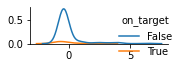

[Text(-0.002, 0, '−0.002'), Text(0.0, 0, '0.000'), Text(0.002, 0, '0.002'), Text(0.004, 0, '0.004'), Text(0.006, 0, '0.006'), Text(0.008, 0, '0.008'), Text(0.01, 0, '0.010'), Text(0.012, 0, '0.012'), Text(0.014, 0, '0.014'), Text(0.016, 0, '0.016')]
[Text(0, -0.005, '−0.005'), Text(0, 0.0, '0.000'), Text(0, 0.005, '0.005'), Text(0, 0.009999999999999998, '0.010'), Text(0, 0.015, '0.015'), Text(0, 0.02, '0.020'), Text(0, 0.024999999999999998, '0.025'), Text(0, 0.030000000000000002, '0.030'), Text(0, 0.035, '0.035'), Text(0, 0.04, '0.040')]


/home/lafleur1/anaconda3/envs/dimsum/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


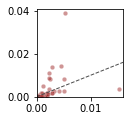

/home/lafleur1/anaconda3/envs/dimsum/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/lafleur1/anaconda3/envs/dimsum/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(-0.025, 0, '−0.025'), Text(0.0, 0, '0.000'), Text(0.025, 0, '0.025'), Text(0.05000000000000001, 0, '0.050'), Text(0.07500000000000001, 0, '0.075'), Text(0.1, 0, '0.100'), Text(0.12500000000000003, 0, '0.125'), Text(0.15000000000000002, 0, '0.150'), Text(0.17500000000000002, 0, '0.175'), Text(0, 0, '')]
[Text(0, -0.05, '−0.05'), Text(0, 0.0, '0.00'), Text(0, 0.05, '0.05'), Text(0, 0.10000000000000002, '0.10'), Text(0, 0.15000000000000002, '0.15'), Text(0, 0.2, '0.20')]


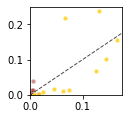

his_l61_size_norm_10mm
0.6516118465469496
0.8998779036835802
------------------------


In [12]:
sns.displot( data = trp_diff_times, x = 'diff_2_10', hue="on_target", kind="kde",height=1.25 , aspect = 1.5)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.tight_layout()
ax.set_xlim(left = 0)
ax.set_ylim(bottom = 0)
locsx, labels = plt.xticks()
print (labels)
#plt.xticks([0,0.01,0.02], [])
locsy, labels = plt.yticks()
print (labels)
#plt.yticks([0,0.01,0.02], [])
plt.xlabel("")
plt.ylabel("")
#resize 
plt.savefig('./figures/' 'fraction_change_2mm.svg', dpi = 300)

plt.show()
    

on_targets = "#ffcc00ff"
off_targets = "#a02c2c"

on_target_df = trp_diff_times[trp_diff_times.on_target == True]
off_target_df = trp_diff_times[trp_diff_times.on_target == False]

for other in ['his_l61_size_norm_10mm']:#, 'trp_l61_size_norm_60']:#', 'log2_enrich_l62', 'log2_enrich_l67', 'avg_log_no_adj_counts']:

    fig, ax = plt.subplots()
    sns.scatterplot(off_target_df['his_l61_size_norm_2mm'], off_target_df[other],color = off_targets, alpha = 0.5,s = 20)
    #sns.scatterplot(on_target_df[other], on_target_df['his_l61_size_norm_2mm'],color = on_targets,s = 10, alpha = 0.75)#, alpha = 0.75))#, alpha = 0.75)
    #plt.xlim(left=0)
    #ax.plot([0,ax.get_xlim()[1]],[0,ax.get_xlim()[1]], ls="--", c=".3")
    plt.tight_layout()
    ax.set_xlim(left = 0)
    ax.set_ylim(bottom = 0)
    locsx, labels = plt.xticks()
    print (labels)
    #plt.xticks([0,0.01,0.02], [])
    locsy, labels = plt.yticks()
    print (labels)
    #plt.yticks([0,0.01,0.02], [])
    plt.xlabel("")
    plt.ylabel("")
    ax.plot([0,ax.get_xlim()[1]],[0,ax.get_xlim()[1]], ls="--", c=".3", linewidth = 1)
    #ax.plot([1/144,1/144],[0,ax.get_ylim()[1]], ls="--", c="red", linewidth = 1)
    #ax.plot([0,ax.get_ylim()[1]], [1/144,1/144], ls="--", c="red", linewidth = 1)
    #resize 
    fig.set_size_inches(1.5, 1.5)
    plt.savefig('./figures/' + other + 'vs_2mm_norm_off.svg', dpi = 300)
    
    plt.show()
    
    
    fig, ax = plt.subplots()
    sns.scatterplot(off_target_df['his_l61_size_norm_2mm'], off_target_df[other],color = off_targets, alpha = 0.5,s = 20)

    #sns.scatterplot(off_target_df['his_l61_size_norm_2mm'], off_target_df[other],color = off_targets, alpha = 0.5,s = 10)
    sns.scatterplot(on_target_df['his_l61_size_norm_2mm'], on_target_df[other],color = on_targets,s =20, alpha = 0.75)#, alpha = 0.75))#, alpha = 0.75)
    #plt.xlim(left=0)
    
    #ax.plot([0,, ax.get_ylim(), ls="--", c=".3")
    plt.tight_layout()
    ax.set_xlim(left = 0)
    ax.set_ylim(bottom = 0)
    locsx, labels = plt.xticks()
    print (labels)
    #plt.xticks([0,0.01,0.02], [])
    locsy, labels = plt.yticks()
    print (labels)
    #plt.yticks([0,0.01,0.02], [])
    plt.xlabel("")
    plt.ylabel("")
    ax.plot([0,ax.get_xlim()[1]],[0,ax.get_xlim()[1]], ls="--", c=".3", linewidth = 1)
    #ax.plot([1/144,1/144],[0,ax.get_ylim()[1]], ls="--", c="red", linewidth = 1)
    #ax.plot([0,ax.get_ylim()[1]], [1/144,1/144], ls="--", c="red", linewidth = 1)
    #resize 
    fig.set_size_inches(1.5, 1.5)
    plt.savefig('./figures/' + other + 'vs_2mm_norm_on.svg', dpi = 300)
    
    plt.show()

    print (other)
    print (stats.pearsonr(trp_diff_times['his_l61_size_norm_2mm'],
                             trp_diff_times[other])[0]**2)
    print (stats.spearmanr(trp_diff_times['his_l61_size_norm_2mm'],
                             trp_diff_times[other])[0])
    print ('------------------------')





In [13]:

trp_diff_times = pd.read_csv("./merged_files/l62_comp_3at.csv")
trp_diff_times = trp_diff_times.rename(columns = {'Unnamed: 0': 'PPI'})

target_orientations = []
target_ppis = []
for i in range(1,13,2):
    #print (i, i + 1)
    target_orientations.append('DBD:Jerala_P' + str(i) + ':AD:Jerala_P' + str(i+1))
    target_orientations.append('DBD:Jerala_P' + str(i+1) + ':AD:Jerala_P' + str(i))
    ppi_label = ['Jerala_P' + str(i) , 'Jerala_P' + str(i+1) ]
    ppi_label.sort()
    target_ppis.append(':'.join(ppi_label))

    
## compare with real values now
true_vals = pd.read_csv('local_copy/bft/twist/l61/NICP_invivo-data.csv')
#DBD:Jerala_P1:AD:Jerala_P1
#true_vals['on_target'] = true_vals.apply(lambda row: abs(row['Peptide1'] - row['Peptide2'])  == 1, axis =1 ) 
true_vals['str_1'] = true_vals['Peptide1'].apply(lambda x: 'Jerala_P' + str(x))
true_vals['str_2'] = true_vals['Peptide2'].apply(lambda x: 'Jerala_P' + str(x))
true_vals['PPI'] = 'DBD:' + true_vals['str_2'] + ':AD:' + true_vals['str_1'] #[df.PPI == 'DBD:' + dbd + ':AD:' + ad]
true_vals['on_target'] = true_vals.PPI.apply(lambda x: x in target_orientations)
print (true_vals.on_target.value_counts())
true_vals['log_fa'] = np.log(true_vals['Fold activation'])
trp_diff_times = trp_diff_times.merge(true_vals, on = 'PPI')
#trp_diff_times[['PPI'] + ashr_cols + list(true_vals.columns)].sort_values(by = 'Fold activation')
from scipy import stats
print (trp_diff_times.his2mm.min())
print (trp_diff_times.his10mm.min())
#print (trp_diff_times.trp60.min())

print (trp_diff_times[trp_diff_times.his2mm == 0].shape)
print (trp_diff_times[trp_diff_times.his10mm == 0].shape)
#print (trp_diff_times.trp60.min())
print (trp_diff_times[trp_diff_times.his2mm == 0])

trp_diff_times = trp_diff_times[(trp_diff_times.his2mm != 0) & (trp_diff_times.his2mm != 0)]

#adjust by read count fractions 

trp_diff_times['his_l61_size_norm_2mm'] = trp_diff_times['his2mm']/trp_diff_times['his2mm'].sum()
trp_diff_times['his_l61_size_norm_10mm'] = trp_diff_times['his10mm']/trp_diff_times['his10mm'].sum()
trp_diff_times['diff_2_10'] = (trp_diff_times['his_l61_size_norm_10mm'] -trp_diff_times['his_l61_size_norm_2mm'])/trp_diff_times['his_l61_size_norm_2mm']

False    132
True      12
Name: on_target, dtype: int64
2
2
(0, 10)
(0, 10)
Empty DataFrame
Columns: [PPI, his2mm, his10mm, Peptide1, Peptide2, Fold activation, str_1, str_2, on_target, log_fa]
Index: []


[Text(-2.5, 0, '−2.5'), Text(0.0, 0, '0.0'), Text(2.5, 0, '2.5'), Text(5.0, 0, '5.0'), Text(0, 0, ''), Text(0, 0, '')]
[Text(0, 0.0, '0'), Text(0, 1.0, '1'), Text(0, 2.0, '2')]


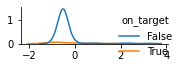

[Text(-0.005, 0, '−0.005'), Text(0.0, 0, '0.000'), Text(0.005, 0, '0.005'), Text(0.009999999999999998, 0, '0.010'), Text(0.015, 0, '0.015'), Text(0.02, 0, '0.020'), Text(0.024999999999999998, 0, '0.025'), Text(0.030000000000000002, 0, '0.030'), Text(0.035, 0, '0.035')]
[Text(0, -0.02, '−0.02'), Text(0, 0.0, '0.00'), Text(0, 0.02, '0.02'), Text(0, 0.039999999999999994, '0.04'), Text(0, 0.06, '0.06'), Text(0, 0.08, '0.08'), Text(0, 0.09999999999999999, '0.10'), Text(0, 0.12000000000000001, '0.12'), Text(0, 0.14, '0.14'), Text(0, 0.16, '0.16')]


/home/lafleur1/anaconda3/envs/dimsum/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


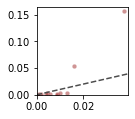

/home/lafleur1/anaconda3/envs/dimsum/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/lafleur1/anaconda3/envs/dimsum/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(-0.025, 0, '−0.025'), Text(0.0, 0, '0.000'), Text(0.025, 0, '0.025'), Text(0.05000000000000001, 0, '0.050'), Text(0.07500000000000001, 0, '0.075'), Text(0.1, 0, '0.100'), Text(0.12500000000000003, 0, '0.125'), Text(0.15000000000000002, 0, '0.150'), Text(0.17500000000000002, 0, '0.175'), Text(0.2, 0, '0.200')]
[Text(0, -0.05, '−0.05'), Text(0, 0.0, '0.00'), Text(0, 0.05, '0.05'), Text(0, 0.10000000000000002, '0.10'), Text(0, 0.15000000000000002, '0.15'), Text(0, 0.2, '0.20'), Text(0, 0.25000000000000006, '0.25')]


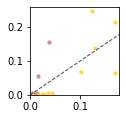

his_l61_size_norm_10mm
0.6868000550015106
0.911847577068479
------------------------


In [14]:
sns.displot( data = trp_diff_times, x = 'diff_2_10', hue="on_target", kind="kde",height=1.25 , aspect = 1.5)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.tight_layout()
ax.set_xlim(left = 0)
ax.set_ylim(bottom = 0)
locsx, labels = plt.xticks()
print (labels)
#plt.xticks([0,0.01,0.02], [])
locsy, labels = plt.yticks()
print (labels)
#plt.yticks([0,0.01,0.02], [])
plt.xlabel("")
plt.ylabel("")
#resize 
plt.savefig('./figures/' 'fraction_change_2mm_l62.svg', dpi = 300)

plt.show()
    

on_targets = "#ffcc00ff"
off_targets = "#a02c2c"

on_target_df = trp_diff_times[trp_diff_times.on_target == True]
off_target_df = trp_diff_times[trp_diff_times.on_target == False]

for other in ['his_l61_size_norm_10mm']:#, 'trp_l61_size_norm_60']:#', 'log2_enrich_l62', 'log2_enrich_l67', 'avg_log_no_adj_counts']:

    fig, ax = plt.subplots()
    sns.scatterplot(off_target_df['his_l61_size_norm_2mm'], off_target_df[other],color = off_targets, alpha = 0.5,s = 20)
    #sns.scatterplot(on_target_df[other], on_target_df['his_l61_size_norm_2mm'],color = on_targets,s = 10, alpha = 0.75)#, alpha = 0.75))#, alpha = 0.75)
    #plt.xlim(left=0)
    #ax.plot([0,ax.get_xlim()[1]],[0,ax.get_xlim()[1]], ls="--", c=".3")
    plt.tight_layout()
    ax.set_xlim(left = 0)
    ax.set_ylim(bottom = 0)
    locsx, labels = plt.xticks()
    print (labels)
    #plt.xticks([0,0.01,0.02], [])
    locsy, labels = plt.yticks()
    print (labels)
    #plt.yticks([0,0.01,0.02], [])
    plt.xlabel("")
    plt.ylabel("")
    ax.plot([0,ax.get_xlim()[1]],[0,ax.get_xlim()[1]], ls="--", c=".3")
    #resize 
    fig.set_size_inches(1.5, 1.5)
    plt.savefig('./figures/' + other + 'vs_2mm_norm_off_l62.svg', dpi = 300)
    
    plt.show()
    
    
    fig, ax = plt.subplots()
    sns.scatterplot(off_target_df['his_l61_size_norm_2mm'], off_target_df[other],color = off_targets, alpha = 0.5,s = 20)
    #sns.scatterplot(off_target_df['his_l61_size_norm_2mm'], off_target_df[other],color = off_targets, alpha = 0.5,s = 10)
    sns.scatterplot(on_target_df['his_l61_size_norm_2mm'], on_target_df[other],color = on_targets,s =20, alpha = 0.75)#, alpha = 0.75))#, alpha = 0.75)
    #plt.xlim(left=0)
    
    #ax.plot([0,, ax.get_ylim(), ls="--", c=".3")
    plt.tight_layout()
    ax.set_xlim(left = 0)
    ax.set_ylim(bottom = 0)
    locsx, labels = plt.xticks()
    print (labels)
    #plt.xticks([0,0.01,0.02], [])
    locsy, labels = plt.yticks()
    print (labels)
    #plt.yticks([0,0.01,0.02], [])
    plt.xlabel("")
    plt.ylabel("")
    ax.plot([0,ax.get_xlim()[1]],[0,ax.get_xlim()[1]], ls="--", c=".3", linewidth = 1)
    #ax.plot([1/144,1/144],[0,ax.get_ylim()[1]], ls="--", c="red", linewidth = 1)
    #ax.plot([0,ax.get_ylim()[1]], [1/144,1/144], ls="--", c="red", linewidth = 1)
    #resize 
    fig.set_size_inches(1.5, 1.5)
    plt.savefig('./figures/' + other + 'vs_2mm_norm_on_l62.svg', dpi = 300)
    
    plt.show()

    print (other)
    print (stats.pearsonr(trp_diff_times['his_l61_size_norm_2mm'],
                             trp_diff_times[other])[0]**2)
    print (stats.spearmanr(trp_diff_times['his_l61_size_norm_2mm'],
                             trp_diff_times[other])[0])
    print ('------------------------')





False    132
True      12
Name: on_target, dtype: int64


<Figure size 432x288 with 0 Axes>

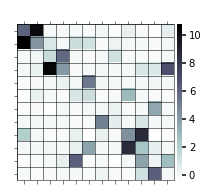

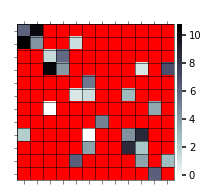

In [112]:
#differences in lfc for 2mM and 10mM



library = "l61_l62_10mM"
homo_out_name = "./merged_files/" + library + "_psuedorep_w_homo_comps.csv"
hetero_out_name = "./merged_files/" + library + "_psuedorep_wo_homo_comps.csv"

drive_location = "./local_copy/bft/twist/l61/"
his_counts = pd.read_csv(drive_location + 'L61_10mM_3AT_HIS_table.csv')
his_counts = his_counts.rename(columns= {'Binder1':'Binder'})
binders = his_counts.Binder.to_list() #S7B is missing from the table
vals_counts = ['PPI', 'count_DBDAD_trp1', 'count_ADDBD_trp1','count_DBDAD_his1', 'count_ADDBD_his1']

flat_df = pd.read_csv('./merged_files/l61_l62_10mM_all_flat.csv')

vals_counts = ['trp1_l61', 'trp1_l62', 'his1_l61', 'his1_l62']
for vc in vals_counts:
    flat_df.loc[flat_df[vc]  == 0, vc] = None

flat_df['lin_enrich_l61'] = calc_lin_enrichment(flat_df['trp1_l61'], flat_df['his1_l61'])
flat_df['log_enrich_l61'] = calc_log_enrichment(flat_df['lin_enrich_l61'])#, deseq2_results['his1'])
flat_df['log2_enrich_l61'] = calc_log2_enrichment(flat_df['lin_enrich_l61'])#, deseq2_results['his1'])

flat_df['lin_enrich_l62'] = calc_lin_enrichment(flat_df['trp1_l62'], flat_df['his1_l62'])
flat_df['log_enrich_l62'] = calc_log_enrichment(flat_df['lin_enrich_l62'])#, deseq2_results['his1'])
flat_df['log2_enrich_l62'] = calc_log2_enrichment(flat_df['lin_enrich_l62'])#, deseq2_results['his1'])

flat_df['trp_l61_size_norm'] = flat_df['trp1_l61'].fillna(flat_df['trp1_l61'].min())/flat_df['trp1_l61'].fillna(flat_df['trp1_l61'].min()).sum()
flat_df['his_l61_size_norm'] = flat_df['his1_l61'].fillna(flat_df['his1_l61'].min())/flat_df['his1_l61'].fillna(flat_df['his1_l61'].min()).sum()

flat_df['trp_l62_size_norm'] = flat_df['trp1_l62'].fillna(flat_df['trp1_l62'].min())/flat_df['trp1_l62'].fillna(flat_df['trp1_l62'].min()).sum()
flat_df['his_l62_size_norm'] = flat_df['his1_l62'].fillna(flat_df['his1_l62'].min())/flat_df['his1_l62'].fillna(flat_df['his1_l62'].min()).sum()

flat_df['detected_trps'] = flat_df['trp1_l61'].isna().astype(int) + flat_df['trp1_l62'].isna().astype(int) 
flat_df['detected_hiss'] = flat_df['his1_l61'].isna().astype(int) + flat_df['his1_l62'].isna().astype(int)

flat_df['sum_trp'] = (1/2) * (flat_df['trp_l61_size_norm'] + flat_df['trp_l62_size_norm'])
flat_df['sum_his'] = (1/2) * (flat_df['his_l61_size_norm'] + flat_df['his_l62_size_norm'])

flat_df['avg_lin_adj_counts'] = flat_df['sum_his']/flat_df['sum_trp']
flat_df['avg_log_adj_counts'] = calc_log_enrichment(flat_df['avg_lin_adj_counts'])
flat_df['avg_log2_adj_counts'] = calc_log2_enrichment(flat_df['avg_lin_adj_counts'])

flat_df['avg_lin_no_adj_counts'] = 0.5 * (flat_df['lin_enrich_l61'] + flat_df['lin_enrich_l62'])
flat_df['avg_log_no_adj_counts'] = calc_log_enrichment(flat_df['avg_lin_no_adj_counts'])
flat_df['avg_log2_no_adj_counts'] = calc_log2_enrichment(flat_df['avg_lin_no_adj_counts'])

#min/max scaled readcounts for trp 
flat_df['trp_l61_size_norm_min_max'] = (flat_df['trp_l61_size_norm'] - flat_df['trp_l61_size_norm'].min()) / (flat_df['trp_l61_size_norm'].max() - flat_df['trp_l61_size_norm'].min())
flat_df['trp_l62_size_norm_min_max'] = (flat_df['trp_l62_size_norm'] - flat_df['trp_l62_size_norm'].min()) / (flat_df['trp_l62_size_norm'].max() - flat_df['trp_l62_size_norm'].min())
flat_df['trp_normed_combo'] = 0.5 * ( flat_df['trp_l61_size_norm'] + flat_df['trp_l62_size_norm_min_max'])

#heatmap of deseq2 values 
#single val correlations 

#examining flat interaction first
deseq2_results = pd.read_csv('./merged_files/l61_l62_10mM_flat_comps.csv')
deseq2_results = deseq2_results.rename(columns = {'Unnamed: 0': 'PPI'})
deseq2_results['sig_p'] = deseq2_results['ashr_padj_HIS_TRP'].isna()


deseq2_results['ashr_log2FoldChange_HIS_TRP2'] = deseq2_results['ashr_log2FoldChange_HIS_TRP']
deseq2_results.loc[deseq2_results['sig_p']  == True, 'ashr_log2FoldChange_HIS_TRP2'] = None

combo = flat_df.merge(deseq2_results[['PPI', 'ashr_log2FoldChange_HIS_TRP', 'ashr_padj_HIS_TRP', 'ashr_lfcSE_HIS_TRP']], on = 'PPI')

#jerala analysis section 
#loading true values here....checking Jerala correlations first 
target_orientations = []
target_ppis = []
for i in range(1,13,2):
    #print (i, i + 1)
    target_orientations.append('DBD:Jerala_P' + str(i) + ':AD:Jerala_P' + str(i+1))
    target_orientations.append('DBD:Jerala_P' + str(i+1) + ':AD:Jerala_P' + str(i))
    ppi_label = ['Jerala_P' + str(i) , 'Jerala_P' + str(i+1) ]
    ppi_label.sort()
    target_ppis.append(':'.join(ppi_label))

    
## compare with real values now
true_vals = pd.read_csv('local_copy/bft/twist/l61/NICP_invivo-data.csv')
#DBD:Jerala_P1:AD:Jerala_P1
#true_vals['on_target'] = true_vals.apply(lambda row: abs(row['Peptide1'] - row['Peptide2'])  == 1, axis =1 ) 
true_vals['str_1'] = true_vals['Peptide1'].apply(lambda x: 'Jerala_P' + str(x))
true_vals['str_2'] = true_vals['Peptide2'].apply(lambda x: 'Jerala_P' + str(x))
true_vals['PPI'] = 'DBD:' + true_vals['str_2'] + ':AD:' + true_vals['str_1'] #[df.PPI == 'DBD:' + dbd + ':AD:' + ad]
true_vals['on_target'] = true_vals.PPI.apply(lambda x: x in target_orientations)
print (true_vals.on_target.value_counts())
true_vals['log_fa'] = np.log(true_vals['Fold activation'])
trp_diff_times_10mM = combo.merge(true_vals, on = 'PPI')
#trp_diff_times[['PPI'] + ashr_cols + list(true_vals.columns)].sort_values(by = 'Fold activation')
from scipy import stats



False    132
True      12
Name: on_target, dtype: int64


<Figure size 432x288 with 0 Axes>

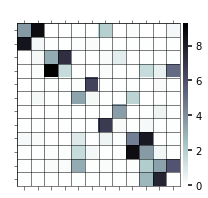

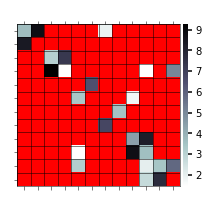

In [113]:
#differences in lfc for 2mM and 10mM



library = "l61_l62_2mM"
homo_out_name = "./merged_files/" + library + "_psuedorep_w_homo_comps.csv"
hetero_out_name = "./merged_files/" + library + "_psuedorep_wo_homo_comps.csv"

drive_location = "./local_copy/bft/twist/l61/"
his_counts = pd.read_csv(drive_location + 'L61_10mM_3AT_HIS_table.csv')
his_counts = his_counts.rename(columns= {'Binder1':'Binder'})
binders = his_counts.Binder.to_list() #S7B is missing from the table
vals_counts = ['PPI', 'count_DBDAD_trp1', 'count_ADDBD_trp1','count_DBDAD_his1', 'count_ADDBD_his1']

flat_df = pd.read_csv('./merged_files/l61_l62_2mM_all_flat.csv')

vals_counts = ['trp1_l61', 'trp1_l62', 'his1_l61', 'his1_l62']
for vc in vals_counts:
    flat_df.loc[flat_df[vc]  == 0, vc] = None

flat_df['lin_enrich_l61'] = calc_lin_enrichment(flat_df['trp1_l61'], flat_df['his1_l61'])
flat_df['log_enrich_l61'] = calc_log_enrichment(flat_df['lin_enrich_l61'])#, deseq2_results['his1'])
flat_df['log2_enrich_l61'] = calc_log2_enrichment(flat_df['lin_enrich_l61'])#, deseq2_results['his1'])

flat_df['lin_enrich_l62'] = calc_lin_enrichment(flat_df['trp1_l62'], flat_df['his1_l62'])
flat_df['log_enrich_l62'] = calc_log_enrichment(flat_df['lin_enrich_l62'])#, deseq2_results['his1'])
flat_df['log2_enrich_l62'] = calc_log2_enrichment(flat_df['lin_enrich_l62'])#, deseq2_results['his1'])

flat_df['trp_l61_size_norm'] = flat_df['trp1_l61'].fillna(flat_df['trp1_l61'].min())/flat_df['trp1_l61'].fillna(flat_df['trp1_l61'].min()).sum()
flat_df['his_l61_size_norm'] = flat_df['his1_l61'].fillna(flat_df['his1_l61'].min())/flat_df['his1_l61'].fillna(flat_df['his1_l61'].min()).sum()

flat_df['trp_l62_size_norm'] = flat_df['trp1_l62'].fillna(flat_df['trp1_l62'].min())/flat_df['trp1_l62'].fillna(flat_df['trp1_l62'].min()).sum()
flat_df['his_l62_size_norm'] = flat_df['his1_l62'].fillna(flat_df['his1_l62'].min())/flat_df['his1_l62'].fillna(flat_df['his1_l62'].min()).sum()

flat_df['detected_trps'] = flat_df['trp1_l61'].isna().astype(int) + flat_df['trp1_l62'].isna().astype(int) 
flat_df['detected_hiss'] = flat_df['his1_l61'].isna().astype(int) + flat_df['his1_l62'].isna().astype(int)

flat_df['sum_trp'] = (1/2) * (flat_df['trp_l61_size_norm'] + flat_df['trp_l62_size_norm'])
flat_df['sum_his'] = (1/2) * (flat_df['his_l61_size_norm'] + flat_df['his_l62_size_norm'])

flat_df['avg_lin_adj_counts'] = flat_df['sum_his']/flat_df['sum_trp']
flat_df['avg_log_adj_counts'] = calc_log_enrichment(flat_df['avg_lin_adj_counts'])
flat_df['avg_log2_adj_counts'] = calc_log2_enrichment(flat_df['avg_lin_adj_counts'])

flat_df['avg_lin_no_adj_counts'] = 0.5 * (flat_df['lin_enrich_l61'] + flat_df['lin_enrich_l62'])
flat_df['avg_log_no_adj_counts'] = calc_log_enrichment(flat_df['avg_lin_no_adj_counts'])
flat_df['avg_log2_no_adj_counts'] = calc_log2_enrichment(flat_df['avg_lin_no_adj_counts'])

#min/max scaled readcounts for trp 
flat_df['trp_l61_size_norm_min_max'] = (flat_df['trp_l61_size_norm'] - flat_df['trp_l61_size_norm'].min()) / (flat_df['trp_l61_size_norm'].max() - flat_df['trp_l61_size_norm'].min())
flat_df['trp_l62_size_norm_min_max'] = (flat_df['trp_l62_size_norm'] - flat_df['trp_l62_size_norm'].min()) / (flat_df['trp_l62_size_norm'].max() - flat_df['trp_l62_size_norm'].min())
flat_df['trp_normed_combo'] = 0.5 * ( flat_df['trp_l61_size_norm'] + flat_df['trp_l62_size_norm_min_max'])

#heatmap of deseq2 values 
#single val correlations 

#examining flat interaction first
deseq2_results = pd.read_csv('./merged_files/l61_l62_2mM_flat_comps.csv')
deseq2_results = deseq2_results.rename(columns = {'Unnamed: 0': 'PPI'})
deseq2_results['sig_p'] = deseq2_results['ashr_padj_HIS_TRP'].isna()


deseq2_results['ashr_log2FoldChange_HIS_TRP2'] = deseq2_results['ashr_log2FoldChange_HIS_TRP']
deseq2_results.loc[deseq2_results['sig_p']  == True, 'ashr_log2FoldChange_HIS_TRP2'] = None

combo = flat_df.merge(deseq2_results[['PPI', 'ashr_log2FoldChange_HIS_TRP', 'ashr_padj_HIS_TRP', 'ashr_lfcSE_HIS_TRP']], on = 'PPI')

#jerala analysis section 
#loading true values here....checking Jerala correlations first 
target_orientations = []
target_ppis = []
for i in range(1,13,2):
    #print (i, i + 1)
    target_orientations.append('DBD:Jerala_P' + str(i) + ':AD:Jerala_P' + str(i+1))
    target_orientations.append('DBD:Jerala_P' + str(i+1) + ':AD:Jerala_P' + str(i))
    ppi_label = ['Jerala_P' + str(i) , 'Jerala_P' + str(i+1) ]
    ppi_label.sort()
    target_ppis.append(':'.join(ppi_label))

    
## compare with real values now
true_vals = pd.read_csv('local_copy/bft/twist/l61/NICP_invivo-data.csv')
#DBD:Jerala_P1:AD:Jerala_P1
#true_vals['on_target'] = true_vals.apply(lambda row: abs(row['Peptide1'] - row['Peptide2'])  == 1, axis =1 ) 
true_vals['str_1'] = true_vals['Peptide1'].apply(lambda x: 'Jerala_P' + str(x))
true_vals['str_2'] = true_vals['Peptide2'].apply(lambda x: 'Jerala_P' + str(x))
true_vals['PPI'] = 'DBD:' + true_vals['str_2'] + ':AD:' + true_vals['str_1'] #[df.PPI == 'DBD:' + dbd + ':AD:' + ad]
true_vals['on_target'] = true_vals.PPI.apply(lambda x: x in target_orientations)
print (true_vals.on_target.value_counts())
true_vals['log_fa'] = np.log(true_vals['Fold activation'])
trp_diff_times_2mM = combo.merge(true_vals, on = 'PPI')
#trp_diff_times[['PPI'] + ashr_cols + list(true_vals.columns)].sort_values(by = 'Fold activation')
from scipy import stats



In [79]:
trp_diff_times_2mM

,PPI,trp1_l61,trp1_l62,his1_l61,his1_l62,lin_enrich_l61,log_enrich_l61,log2_enrich_l61,lin_enrich_l62,log_enrich_l62,...,ashr_log2FoldChange_HIS_TRP,ashr_padj_HIS_TRP,ashr_lfcSE_HIS_TRP,Peptide1,Peptide2,Fold activation,str_1,str_2,on_target,log_fa
0,DBD:Jerala_P1:AD:Jerala_P1,14.0,5.0,9.0,13.0,0.518766,-0.656302,-0.946844,2.316751,0.840166,...,3.659673,1.468723e-04,0.871761,1,1,0.303852,Jerala_P1,Jerala_P1,False,-1.191216
1,DBD:Jerala_P1:AD:Jerala_P2,1356.0,1523.0,62934.0,53793.0,37.452665,3.623078,5.226996,31.472543,3.449116,...,8.736405,5.053170e-60,0.529786,2,1,957.606968,Jerala_P2,Jerala_P1,True,6.864437
2,DBD:Jerala_P1:AD:Jerala_P3,3068.0,4103.0,215.0,210.0,0.056551,-2.872613,-4.144304,0.045606,-3.087712,...,-0.029963,7.868250e-01,0.182203,3,1,0.364857,Jerala_P3,Jerala_P1,False,-1.008249
3,DBD:Jerala_P1:AD:Jerala_P4,1644.0,2693.0,129.0,167.0,0.063321,-2.759545,-3.981181,0.055257,-2.895763,...,-0.014812,7.894001e-01,0.159187,4,1,0.421157,Jerala_P4,Jerala_P1,False,-0.864748
4,DBD:Jerala_P1:AD:Jerala_P5,2895.0,5479.0,251.0,289.0,0.069965,-2.659757,-3.837218,0.047001,-3.057597,...,-0.020756,7.894001e-01,0.176914,5,1,0.347053,Jerala_P5,Jerala_P1,False,-1.058278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,DBD:Jerala_P12:AD:Jerala_P8,3097.0,2890.0,217.0,194.0,0.056543,-2.872761,-4.144519,0.059815,-2.816499,...,-0.014068,7.894001e-01,0.123704,8,12,0.088908,Jerala_P8,Jerala_P12,False,-2.420152
140,DBD:Jerala_P12:AD:Jerala_P9,2249.0,1442.0,144.0,241.0,0.051669,-2.962897,-4.274557,0.148922,-1.904335,...,0.015280,7.894001e-01,0.163738,9,12,0.083500,Jerala_P9,Jerala_P12,False,-2.482909
141,DBD:Jerala_P12:AD:Jerala_P10,3112.0,3535.0,496.0,5395.0,0.128617,-2.050914,-2.958844,1.359903,0.307414,...,2.733677,1.836872e-02,1.647019,10,12,0.140812,Jerala_P10,Jerala_P12,False,-1.960331
142,DBD:Jerala_P12:AD:Jerala_P11,1503.0,822.0,35130.0,15002.0,18.861501,2.937123,4.237373,16.262350,2.788853,...,7.740452,1.769396e-33,0.634342,11,12,353.898167,Jerala_P11,Jerala_P12,True,5.869009


In [80]:
trp_diff_times_10mM

,PPI,trp1_l61,trp1_l62,his1_l61,his1_l62,lin_enrich_l61,log_enrich_l61,log2_enrich_l61,lin_enrich_l62,log_enrich_l62,...,ashr_log2FoldChange_HIS_TRP,ashr_padj_HIS_TRP,ashr_lfcSE_HIS_TRP,Peptide1,Peptide2,Fold activation,str_1,str_2,on_target,log_fa
0,DBD:Jerala_P1:AD:Jerala_P1,14.0,5.0,36.0,26.0,2.302240,0.833882,1.203038,4.324825,1.464372,...,6.105679,1.100164e-23,0.593946,1,1,0.303852,Jerala_P1,Jerala_P1,False,-1.191216
1,DBD:Jerala_P1:AD:Jerala_P2,1356.0,1523.0,102351.0,61887.0,67.578485,4.213290,6.078492,33.795957,3.520341,...,10.229515,2.574693e-182,0.353906,2,1,957.606968,Jerala_P2,Jerala_P1,True,6.864437
2,DBD:Jerala_P1:AD:Jerala_P3,3068.0,4103.0,120.0,137.0,0.035019,-3.351869,-4.835724,0.027771,-3.583780,...,-0.076252,6.791595e-01,0.219207,3,1,0.364857,Jerala_P3,Jerala_P1,False,-1.008249
3,DBD:Jerala_P1:AD:Jerala_P4,1644.0,2693.0,81.0,72.0,0.044112,-3.121018,-4.502677,0.022236,-3.806032,...,-0.097858,6.100913e-01,0.218979,4,1,0.421157,Jerala_P4,Jerala_P1,False,-0.864748
4,DBD:Jerala_P1:AD:Jerala_P5,2895.0,5479.0,122.0,164.0,0.037730,-3.277299,-4.728142,0.024895,-3.693098,...,-0.061846,7.070202e-01,0.243823,5,1,0.347053,Jerala_P5,Jerala_P1,False,-1.058278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,DBD:Jerala_P12:AD:Jerala_P8,3097.0,2890.0,97.0,110.0,0.028042,-3.574057,-5.156275,0.031656,-3.452818,...,-0.109935,5.627963e-01,0.208881,8,12,0.088908,Jerala_P8,Jerala_P12,False,-2.420152
140,DBD:Jerala_P12:AD:Jerala_P9,2249.0,1442.0,63.0,57.0,0.025080,-3.685685,-5.317320,0.032876,-3.415022,...,-0.142197,4.282853e-01,0.217956,9,12,0.083500,Jerala_P9,Jerala_P12,False,-2.482909
141,DBD:Jerala_P12:AD:Jerala_P10,3112.0,3535.0,209.0,1860.0,0.060129,-2.811266,-4.055799,0.437612,-0.826424,...,1.156627,1.212834e-01,1.591138,10,12,0.140812,Jerala_P10,Jerala_P12,False,-1.960331
142,DBD:Jerala_P12:AD:Jerala_P11,1503.0,822.0,6321.0,2571.0,3.765328,1.325835,1.912776,2.601330,0.956023,...,6.183904,1.049033e-12,0.832973,11,12,353.898167,Jerala_P11,Jerala_P12,True,5.869009


In [81]:
cols_keep = ['lin_enrich_l61', 'log_enrich_l61', 'log2_enrich_l61',
       'lin_enrich_l62',  'log_enrich_l62',  'log2_enrich_l62', 'avg_lin_no_adj_counts',
       'avg_log_no_adj_counts', 'avg_log2_no_adj_counts', 'trp_normed_combo',  'ashr_log2FoldChange_HIS_TRP', 'ashr_padj_HIS_TRP',
       'ashr_lfcSE_HIS_TRP']
mtf_2mM = trp_diff_times_2mM[['PPI'] + cols_keep]
new_names ={}
for c in cols_keep:
    new_names[c] = c+ '_2mM'
mtf_2mM = mtf_2mM.rename(columns = new_names)
cols_keep = ['lin_enrich_l61', 'log_enrich_l61', 'log2_enrich_l61',
       'lin_enrich_l62',  'log_enrich_l62',  'log2_enrich_l62', 'avg_lin_no_adj_counts',
       'avg_log_no_adj_counts', 'avg_log2_no_adj_counts', 'trp_normed_combo',  'ashr_log2FoldChange_HIS_TRP', 'ashr_padj_HIS_TRP',
       'ashr_lfcSE_HIS_TRP']
mtf_10mM = trp_diff_times_10mM[['PPI'] + cols_keep + ['Fold activation', 'on_target', 'log_fa']]
new_names ={}
for c in cols_keep:
    new_names[c] = c+ '_10mM'
mtf_10mM = mtf_10mM.rename(columns = new_names)

compare = mtf_10mM.merge(mtf_2mM, how = 'left', on = 'PPI')

In [82]:
compare

,PPI,lin_enrich_l61_10mM,log_enrich_l61_10mM,log2_enrich_l61_10mM,lin_enrich_l62_10mM,log_enrich_l62_10mM,log2_enrich_l62_10mM,avg_lin_no_adj_counts_10mM,avg_log_no_adj_counts_10mM,avg_log2_no_adj_counts_10mM,...,lin_enrich_l62_2mM,log_enrich_l62_2mM,log2_enrich_l62_2mM,avg_lin_no_adj_counts_2mM,avg_log_no_adj_counts_2mM,avg_log2_no_adj_counts_2mM,trp_normed_combo_2mM,ashr_log2FoldChange_HIS_TRP_2mM,ashr_padj_HIS_TRP_2mM,ashr_lfcSE_HIS_TRP_2mM
0,DBD:Jerala_P1:AD:Jerala_P1,2.302240,0.833882,1.203038,4.324825,1.464372,2.112642,3.313532,1.198015,1.728370,...,2.316751,0.840166,1.212103,1.417758,0.349077,0.503612,0.000064,3.659673,1.468723e-04,0.871761
1,DBD:Jerala_P1:AD:Jerala_P2,67.578485,4.213290,6.078492,33.795957,3.520341,5.078779,50.687221,3.925674,5.663550,...,31.472543,3.449116,4.976022,34.462604,3.539875,5.106960,0.070787,8.736405,5.053170e-60,0.529786
2,DBD:Jerala_P1:AD:Jerala_P3,0.035019,-3.351869,-4.835724,0.027771,-3.583780,-5.170301,0.031395,-3.461116,-4.993335,...,0.045606,-3.087712,-4.454627,0.051079,-2.974390,-4.291138,0.190251,-0.029963,7.868250e-01,0.182203
3,DBD:Jerala_P1:AD:Jerala_P4,0.044112,-3.121018,-4.502677,0.022236,-3.806032,-5.490943,0.033174,-3.405981,-4.913792,...,0.055257,-2.895763,-4.177703,0.059289,-2.825336,-4.076099,0.124329,-0.014812,7.894001e-01,0.159187
4,DBD:Jerala_P1:AD:Jerala_P5,0.037730,-3.277299,-4.728142,0.024895,-3.693098,-5.328015,0.031312,-3.463741,-4.997122,...,0.047001,-3.057597,-4.411180,0.058483,-2.839021,-4.095842,0.252555,-0.020756,7.894001e-01,0.176914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,DBD:Jerala_P12:AD:Jerala_P8,0.028042,-3.574057,-5.156275,0.031656,-3.452818,-4.981364,0.029849,-3.511602,-5.066170,...,0.059815,-2.816499,-4.063350,0.058179,-2.844235,-4.103363,0.135167,-0.014068,7.894001e-01,0.123704
140,DBD:Jerala_P12:AD:Jerala_P9,0.025080,-3.685685,-5.317320,0.032876,-3.415022,-4.926835,0.028978,-3.541224,-5.108907,...,0.148922,-1.904335,-2.747375,0.100295,-2.299636,-3.317674,0.068266,0.015280,7.894001e-01,0.163738
141,DBD:Jerala_P12:AD:Jerala_P10,0.060129,-2.811266,-4.055799,0.437612,-0.826424,-1.192277,0.248870,-1.390824,-2.006535,...,1.359903,0.307414,0.443504,0.744260,-0.295365,-0.426121,0.164497,2.733677,1.836872e-02,1.647019
142,DBD:Jerala_P12:AD:Jerala_P11,3.765328,1.325835,1.912776,2.601330,0.956023,1.379250,3.183329,1.157928,1.670536,...,16.262350,2.788853,4.023464,17.561926,2.865733,4.134379,0.039123,7.740452,1.769396e-33,0.634342


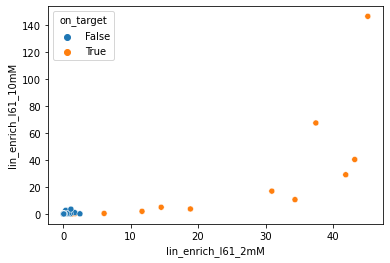

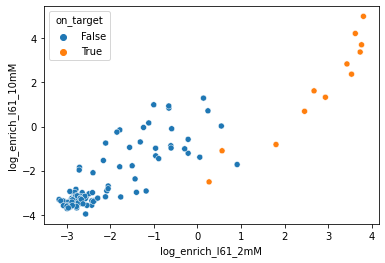

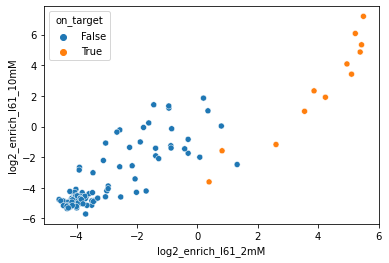

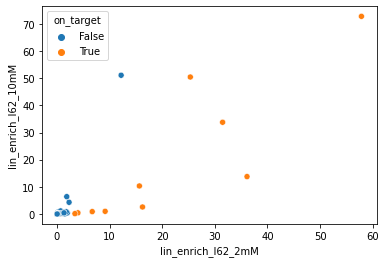

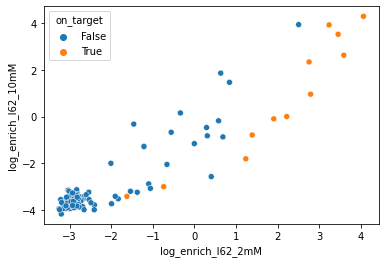

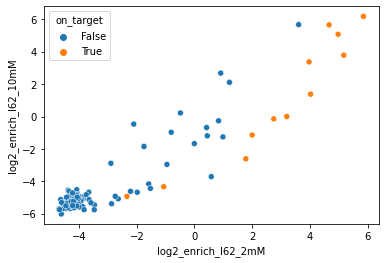

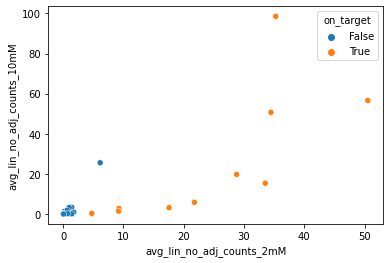

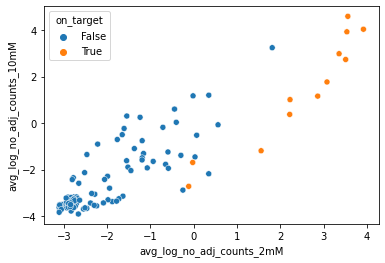

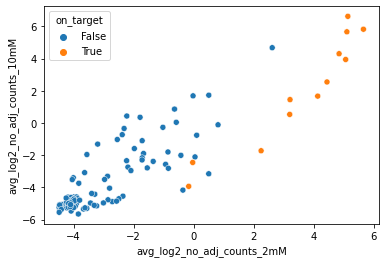

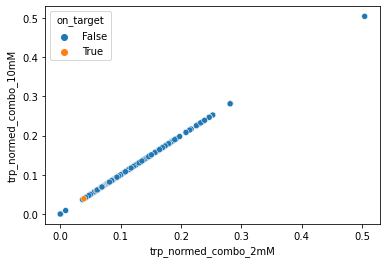

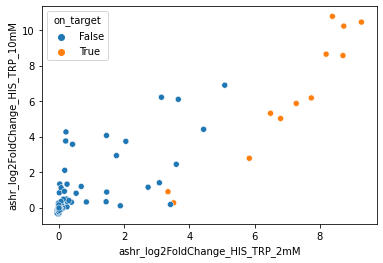

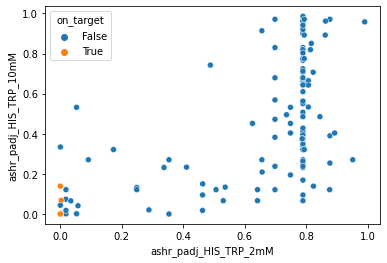

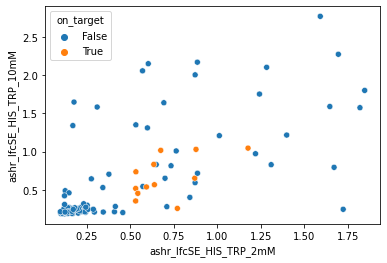

In [83]:
for c in ['lin_enrich_l61', 'log_enrich_l61', 'log2_enrich_l61',
       'lin_enrich_l62',  'log_enrich_l62',  'log2_enrich_l62', 'avg_lin_no_adj_counts',
       'avg_log_no_adj_counts', 'avg_log2_no_adj_counts', 'trp_normed_combo',  'ashr_log2FoldChange_HIS_TRP', 'ashr_padj_HIS_TRP',
       'ashr_lfcSE_HIS_TRP']:
    fig = plt.figure()
    sns.scatterplot(data = compare, x = c +'_2mM', y = c + '_10mM', hue = 'on_target')
    plt.show()

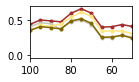

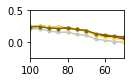

[0.4393131246668022, 0.5009441859212096, 0.48770205391149773, 0.4750710563685339, 0.5942733520114216, 0.6591031247449797, 0.5963799880957703, 0.3989901351669316, 0.4055989981754412, 0.43598266024435217, 0.40891849292532384, 0.00019955208722749308, 0.006506417032800739, 0.007638702012895451, 0.007137437055274814, 0.024737066075148598, 0.03554439265104744, 0.05994626218373559, 0.10166741210034361, 0.061296880504947075]
[0.2477935857246202, 0.25312246553122464, 0.23866279069767446, 0.23438228014579288, 0.22330939793261265, 0.20121562014728436, 0.1734187536400699, 0.11496225120109813, 0.09607056936647954, 0.07105647517039922, 0.05296160524792592, -0.04562937062937063, -0.12965640284228985, -0.13312217194570136, -0.11929930534581698, 0.02265122265122265, -0.08522167487684727, -0.033314511575381144, 0.028571428571428564, -0.6428571428571429]


In [135]:
#do r2 with decreasing percentile of avg trp library normalized values 
#trp_normed_combo

ashr_pearson = []
ashr_spearman = []

l61_pearson = []
l61_spearman = []

l62_pearson = []
l62_spearman = []

l67_pearson = []
l67_spearman = []

log_avg_lin_pearson = []
log_avg_lin_spearman = []

log_avg_lin_adj_pearson = []
log_avg_lin_adj_spearman = []

percentiles = []
#with higher and lower 
for p in list(range(0,100,5)):
    #linear activation 
    
    percentile_cutoff = np.percentile(compare.trp_normed_combo_10mM.to_list(),p)
    percentiles.append(100-p)
    temp = compare[compare.trp_normed_combo_10mM >= percentile_cutoff]
    #print (p, temp.shape, temp.on_target.value_counts())
    ashr_pearson.append(stats.pearsonr(temp['ashr_log2FoldChange_HIS_TRP_10mM'],
                         np.log(temp['Fold activation']))[0]**2)

    ashr_spearman.append(stats.spearmanr(temp['ashr_log2FoldChange_HIS_TRP_10mM'],
                         np.log(temp['Fold activation']))[0])
    
    l61_pearson.append(stats.pearsonr(temp['log2_enrich_l61_10mM'],
                         np.log(temp['Fold activation']))[0]**2)

    l61_spearman.append(stats.spearmanr(temp['log2_enrich_l61_10mM'],
                         np.log(temp['Fold activation']))[0])
    
    l62_pearson.append(stats.pearsonr(temp['log2_enrich_l62_10mM'],
                         np.log(temp['Fold activation']))[0]**2)

    l62_spearman.append(stats.spearmanr(temp['log2_enrich_l62_10mM'],
                         np.log(temp['Fold activation']))[0])
    
    
    log_avg_lin_pearson.append(stats.pearsonr(temp['avg_log2_no_adj_counts_10mM'],
                         np.log(temp['Fold activation']))[0]**2)

    log_avg_lin_spearman.append(stats.spearmanr(temp['avg_log2_no_adj_counts_10mM'],
                         np.log(temp['Fold activation']))[0])
    
    
    plt.show()

    
color_ashr = '#a02c2c'
color_avg = '#806600'
color_l67 = '#d4aa00'
color_l62 = '#ffe680'
color_l61 = '#c4c8b7'
markersize = 3
figure = plt.figure()    
plt.plot(percentiles, ashr_pearson,  marker = 'o', color = color_ashr, label = 'ashr pearson r^2', markersize = markersize)
plt.plot(percentiles, l61_pearson,  marker = 'o', color = color_l61, label = 'l61 pearson r^2', markersize = markersize)
plt.plot(percentiles, l62_pearson,  marker = 'o', color = color_l62,  label = 'l62 pearson r^2', markersize = markersize)
#plt.plot(percentiles, l67_pearson,  marker = 'o', color = color_l67, label = 'l67 pearson r^2', markersize = markersize)
plt.plot(percentiles, log_avg_lin_pearson,  marker = 'o', color = color_avg, label = 'log avg no adj lin pearson r^2', markersize = markersize)
#plt.ylim([0,0.9])
#plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],[])
#plt.xticks([100,90,80,70,60,50],[100,])
plt.xlim([100,50])
figure.set_size_inches(2.125,1.25)
plt.tight_layout()
figure.set_size_inches(2.125,1.25)
plt.savefig('./figures/pearson_trp_dec_10.svg', dpi = 300)
plt.show()

figure = plt.figure()
plt.plot(percentiles, ashr_spearman,  marker = 'o', color = color_ashr, label = 'ashr pearson r^2', markersize = markersize)
plt.plot(percentiles, l61_spearman,  marker = 'o', color = color_l61, label = 'l61 pearson r^2', markersize = markersize)
plt.plot(percentiles, l62_spearman,  marker = 'o', color = color_l62,  label = 'l62 pearson r^2', markersize = markersize)
#plt.plot(percentiles, l67_spearman,  marker = 'o', color = color_l67, label = 'l67 pearson r^2', markersize = markersize)
plt.plot(percentiles, log_avg_lin_spearman,  marker = 'o', color = color_avg, label = 'log avg no adj lin pearson r^2', markersize = markersize)
plt.ylim([-0.25,0.5])
#plt.yticks([-0.1,0,0.1,0.2,0.3,0.4],[])
#plt.xticks([100,90,80,70,60,50],[])
plt.xlim([100,50])
figure.set_size_inches(2.125,1.25)
plt.tight_layout()
figure.set_size_inches(2.125,1.25)
plt.savefig('./figures/spearman_trp_dec_10mm.svg', dpi = 300)
plt.show()

print (ashr_pearson)
print (ashr_spearman)

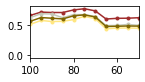

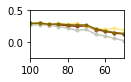

[0.6508961294193807, 0.7048689818846399, 0.6982727248123887, 0.6979510719412624, 0.7402175518349494, 0.7594656534039548, 0.7245769996538357, 0.5924952049731318, 0.6035158345971343, 0.6057319049830246, 0.6133190601552653, 0.002774029843202517, 0.012910859280879292, 0.016274675405016953, 0.0015164459593571184, 0.04591205230684247, 0.0718457376431977, 0.04349467366718891, 0.3129471110808696, 0.1271996806704819]
[0.29360983843742466, 0.2971470826773532, 0.2762913685152058, 0.27521222915792365, 0.2568847155369684, 0.24868768279554523, 0.25393127548048916, 0.19548804870042671, 0.1690174064814378, 0.14118792599805258, 0.1265676249276481, 0.020236013986013986, -0.0545387431172906, -0.07619909502262442, -0.051646028390214434, 0.1716859716859717, 0.09802955665024629, -0.02766798418972332, 0.11785714285714284, -0.7857142857142858]


In [133]:
#do r2 with decreasing percentile of avg trp library normalized values 
#trp_normed_combo

ashr_pearson = []
ashr_spearman = []

l61_pearson = []
l61_spearman = []

l62_pearson = []
l62_spearman = []

l67_pearson = []
l67_spearman = []

log_avg_lin_pearson = []
log_avg_lin_spearman = []

log_avg_lin_adj_pearson = []
log_avg_lin_adj_spearman = []

percentiles = []
#with higher and lower 
for p in list(range(0,100,5)):
    #linear activation 
    
    percentile_cutoff = np.percentile(compare.trp_normed_combo_10mM.to_list(),p)
    percentiles.append(100-p)
    temp = compare[compare.trp_normed_combo_10mM >= percentile_cutoff]
    #print (p, temp.shape, temp.on_target.value_counts())
    ashr_pearson.append(stats.pearsonr(temp['ashr_log2FoldChange_HIS_TRP_2mM'],
                         np.log(temp['Fold activation']))[0]**2)

    ashr_spearman.append(stats.spearmanr(temp['ashr_log2FoldChange_HIS_TRP_2mM'],
                         np.log(temp['Fold activation']))[0])
    
    l61_pearson.append(stats.pearsonr(temp['log2_enrich_l61_2mM'],
                         np.log(temp['Fold activation']))[0]**2)

    l61_spearman.append(stats.spearmanr(temp['log2_enrich_l61_2mM'],
                         np.log(temp['Fold activation']))[0])
    
    l62_pearson.append(stats.pearsonr(temp['log2_enrich_l62_2mM'],
                         np.log(temp['Fold activation']))[0]**2)

    l62_spearman.append(stats.spearmanr(temp['log2_enrich_l62_2mM'],
                         np.log(temp['Fold activation']))[0])
    
    
    log_avg_lin_pearson.append(stats.pearsonr(temp['avg_log2_no_adj_counts_2mM'],
                         np.log(temp['Fold activation']))[0]**2)

    log_avg_lin_spearman.append(stats.spearmanr(temp['avg_log2_no_adj_counts_2mM'],
                         np.log(temp['Fold activation']))[0])
    
    
    plt.show()

    
color_ashr = '#a02c2c'
color_avg = '#806600'
color_l67 = '#d4aa00'
color_l62 = '#ffe680'
color_l61 = '#c4c8b7'
markersize = 3
figure = plt.figure()    
plt.plot(percentiles, ashr_pearson,  marker = 'o', color = color_ashr, label = 'ashr pearson r^2', markersize = markersize)
plt.plot(percentiles, l61_pearson,  marker = 'o', color = color_l61, label = 'l61 pearson r^2', markersize = markersize)
plt.plot(percentiles, l62_pearson,  marker = 'o', color = color_l62,  label = 'l62 pearson r^2', markersize = markersize)
#plt.plot(percentiles, l67_pearson,  marker = 'o', color = color_l67, label = 'l67 pearson r^2', markersize = markersize)
plt.plot(percentiles, log_avg_lin_pearson,  marker = 'o', color = color_avg, label = 'log avg no adj lin pearson r^2', markersize = markersize)
#plt.ylim([0,0.9])
#plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],[])
#plt.xticks([100,90,80,70,60,50],[100,])
plt.xlim([100,50])

figure.set_size_inches(2.125,1.25)
plt.tight_layout()
figure.set_size_inches(2.125,1.25)
plt.savefig('./figures/pearson_trp_dec_2.svg', dpi = 300)
plt.show()

figure = plt.figure()
plt.plot(percentiles, ashr_spearman,  marker = 'o', color = color_ashr, label = 'ashr pearson r^2', markersize = markersize)
plt.plot(percentiles, l61_spearman,  marker = 'o', color = color_l61, label = 'l61 pearson r^2', markersize = markersize)
plt.plot(percentiles, l62_spearman,  marker = 'o', color = color_l62,  label = 'l62 pearson r^2', markersize = markersize)
#plt.plot(percentiles, l67_spearman,  marker = 'o', color = color_l67, label = 'l67 pearson r^2', markersize = markersize)
plt.plot(percentiles, log_avg_lin_spearman,  marker = 'o', color = color_avg, label = 'log avg no adj lin pearson r^2', markersize = markersize)
plt.ylim([-0.25,0.5])
#plt.yticks([-0.1,0,0.1,0.2,0.3,0.4],[])
#plt.xticks([100,90,80,70,60,50],[])
plt.xlim([100,50])

figure.set_size_inches(2.125,1.25)
plt.tight_layout()
figure.set_size_inches(2.125,1.25)
plt.savefig('./figures/spearman_trp_dec_2mm.svg', dpi = 300)
plt.show()

print (ashr_pearson)
print (ashr_spearman)

100
95
90
85
80
75
70
65
60
55
50
45
40
35
30
25
20
15
10
5


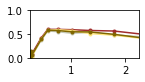

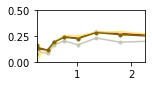

[0.4393131246668022, 0.5649952148481723, 0.5765115727416766, 0.5932789235129119, 0.6000126683937177, 0.5998166509950461, 0.42226315894332545, 0.0848937095687249, 0.12452896344901522, 0.006489324569267411, 0.00995916938371863, 0.008176271638569692, 0.022272971294786635, 0.00999229795182297, 0.006458203548574303, 0.010669392306357819, 0.0070417511293770964, 0.015608782898147825, 0.0932858727571749, 0.47620880276117067]
[0.2477935857246202, 0.2742712656838891, 0.28973613595706627, 0.22978907610509514, 0.24501696520160973, 0.19342269475168383, 0.11252184041933606, 0.12734624451672583, 0.12458134817680079, 0.0813047711781889, 0.09881664415718054, 0.0645979020979021, 0.1318096527115568, 0.08226244343891402, 0.040018121413470255, 0.10244530244530246, 0.08226600985221673, -0.1202710333145116, -0.39999999999999997, -0.6666666666666669]


In [130]:
#do r2 with decreasing percentile of avg trp library normalized values 
#trp_normed_combo

ashr_pearson = []
ashr_spearman = []

l61_pearson = []
l61_spearman = []

l62_pearson = []
l62_spearman = []

l67_pearson = []
l67_spearman = []

log_avg_lin_pearson = []
log_avg_lin_spearman = []

log_avg_lin_adj_pearson = []
log_avg_lin_adj_spearman = []

percentiles = []
#with higher and lower 
for p in list(range(100,0,-5)):
    #linear activation 
    print (p)
    percentile_cutoff = np.percentile(compare.ashr_lfcSE_HIS_TRP_10mM.to_list(),p)
    percentiles.append(percentile_cutoff)
    temp = compare[compare.ashr_lfcSE_HIS_TRP_10mM <= percentile_cutoff]
    #print (temp.shape, p, percentile_cutoff, temp.on_target.value_counts())
    ashr_pearson.append(stats.pearsonr(temp['ashr_log2FoldChange_HIS_TRP_10mM'],
                         np.log(temp['Fold activation']))[0]**2)

    ashr_spearman.append(stats.spearmanr(temp['ashr_log2FoldChange_HIS_TRP_10mM'],
                         np.log(temp['Fold activation']))[0])
    
    l61_pearson.append(stats.pearsonr(temp['log2_enrich_l61_10mM'],
                         np.log(temp['Fold activation']))[0]**2)

    l61_spearman.append(stats.spearmanr(temp['log2_enrich_l61_10mM'],
                         np.log(temp['Fold activation']))[0])
    
    l62_pearson.append(stats.pearsonr(temp['log2_enrich_l62_10mM'],
                         np.log(temp['Fold activation']))[0]**2)

    l62_spearman.append(stats.spearmanr(temp['log2_enrich_l62_10mM'],
                         np.log(temp['Fold activation']))[0])
    
    
    log_avg_lin_pearson.append(stats.pearsonr(temp['avg_log2_no_adj_counts_10mM'],
                         np.log(temp['Fold activation']))[0]**2)

    log_avg_lin_spearman.append(stats.spearmanr(temp['avg_log2_no_adj_counts_10mM'],
                         np.log(temp['Fold activation']))[0])
    
color_ashr = '#a02c2c'
color_avg = '#806600'
color_l67 = '#d4aa00'
color_l62 = '#ffe680'
color_l61 = '#c4c8b7'
markersize = 3
figure = plt.figure()    
plt.plot(percentiles, ashr_pearson,  marker = 'o', color = color_ashr, label = 'ashr pearson r^2', markersize = markersize)
plt.plot(percentiles, l61_pearson,  marker = 'o', color = color_l61, label = 'l61 pearson r^2', markersize = markersize)
plt.plot(percentiles, l62_pearson,  marker = 'o', color = color_l62,  label = 'l62 pearson r^2', markersize = markersize)
#plt.plot(percentiles, l67_pearson,  marker = 'o', color = color_l67, label = 'l67 pearson r^2', markersize = markersize)
plt.plot(percentiles, log_avg_lin_pearson,  marker = 'o', color = color_avg, label = 'log avg no adj lin pearson r^2', markersize = markersize)
plt.ylim([0,1.0])
#plt.yticks([0,0.2,0.4,0.6,0.8,1.0],[])
#plt.xticks([50,60,70,80,90,100])#,90,80,70,60,50],[])
#plt.xlim([50,100])
plt.xlim([0.25,2.25])
#plt.xticks([0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25],[])#,90,80,70,60,50],[])
figure.set_size_inches(2.125,1.25)
plt.tight_layout()
figure.set_size_inches(2.125,1.25)
plt.savefig('./figures/pearson_lfsce_10.svg', dpi = 300)
plt.show()

figure = plt.figure()
plt.plot(percentiles, ashr_spearman,  marker = 'o', color = color_ashr, label = 'ashr pearson r^2', markersize = markersize)
plt.plot(percentiles, l61_spearman,  marker = 'o', color = color_l61, label = 'l61 pearson r^2', markersize = markersize)
plt.plot(percentiles, l62_spearman,  marker = 'o', color = color_l62,  label = 'l62 pearson r^2', markersize = markersize)
#plt.plot(percentiles, l67_spearman,  marker = 'o', color = color_l67, label = 'l67 pearson r^2', markersize = markersize)
plt.plot(percentiles, log_avg_lin_spearman,  marker = 'o', color = color_avg, label = 'log avg no adj lin pearson r^2', markersize = markersize)
plt.ylim([0,0.5])
#plt.yticks([-0.1,0,0.1,0.2,0.3,0.4],[])
#plt.xticks([100,90,80,70,60,50],[])
plt.xlim([0.25,2.25])
#plt.xticks([0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25],[])
figure.set_size_inches(2.125,1.25)
plt.tight_layout()
figure.set_size_inches(2.125,1.25)
plt.savefig('./figures/spearman_lfsce_10.svg', dpi = 300)
plt.show()


print (ashr_pearson)
print (ashr_spearman)

100
95
90
85
80
75
70
65
60
55
50
45
40
35
30
25
20
15
10
5


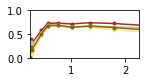

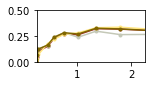

[0.6508961294193807, 0.7239052254732105, 0.7402604100408274, 0.7140345568829686, 0.7316735765470304, 0.7277738850163729, 0.5770373321365767, 0.3033729955031097, 0.39200074496974363, 0.00038913490308761605, 0.0054539119451206255, 0.00715279891560621, 0.008938221859875818, 0.02371571652300605, 0.029561389621790304, 0.023452477655088642, 0.04502843636340234, 0.029001969987405164, 0.024883004224752692, 0.11306031640860753]
[0.29360983843742466, 0.317918992414484, 0.3224675760286226, 0.2628403184180873, 0.27472579499723826, 0.2287290291234388, 0.14942341292952824, 0.10609948971979348, 0.04706825793669513, -0.0009250243427458617, -0.026239629558170947, -0.008435314685314685, 0.016764588267864287, 0.11755656108597284, 0.09121111446692841, 0.09498069498069499, 0.04236453201970442, -0.0220214568040655, -0.11071428571428568, -0.1666666666666667]


In [131]:
#do r2 with decreasing percentile of avg trp library normalized values 
#trp_normed_combo

ashr_pearson = []
ashr_spearman = []

l61_pearson = []
l61_spearman = []

l62_pearson = []
l62_spearman = []

l67_pearson = []
l67_spearman = []

log_avg_lin_pearson = []
log_avg_lin_spearman = []

log_avg_lin_adj_pearson = []
log_avg_lin_adj_spearman = []

percentiles = []
#with higher and lower 
for p in list(range(100,0,-5)):
    #linear activation 
    print (p)
    percentile_cutoff = np.percentile(compare.ashr_lfcSE_HIS_TRP_10mM.to_list(),p)
    percentiles.append(percentile_cutoff)
    temp = compare[compare.ashr_lfcSE_HIS_TRP_10mM <= percentile_cutoff]
    #print (temp.shape, p, percentile_cutoff, temp.on_target.value_counts())
    ashr_pearson.append(stats.pearsonr(temp['ashr_log2FoldChange_HIS_TRP_2mM'],
                         np.log(temp['Fold activation']))[0]**2)

    ashr_spearman.append(stats.spearmanr(temp['ashr_log2FoldChange_HIS_TRP_2mM'],
                         np.log(temp['Fold activation']))[0])
    
    l61_pearson.append(stats.pearsonr(temp['log2_enrich_l61_2mM'],
                         np.log(temp['Fold activation']))[0]**2)

    l61_spearman.append(stats.spearmanr(temp['log2_enrich_l61_2mM'],
                         np.log(temp['Fold activation']))[0])
    
    l62_pearson.append(stats.pearsonr(temp['log2_enrich_l62_2mM'],
                         np.log(temp['Fold activation']))[0]**2)

    l62_spearman.append(stats.spearmanr(temp['log2_enrich_l62_2mM'],
                         np.log(temp['Fold activation']))[0])
    
    
    log_avg_lin_pearson.append(stats.pearsonr(temp['avg_log2_no_adj_counts_2mM'],
                         np.log(temp['Fold activation']))[0]**2)

    log_avg_lin_spearman.append(stats.spearmanr(temp['avg_log2_no_adj_counts_2mM'],
                         np.log(temp['Fold activation']))[0])
    
color_ashr = '#a02c2c'
color_avg = '#806600'
color_l67 = '#d4aa00'
color_l62 = '#ffe680'
color_l61 = '#c4c8b7'
markersize = 3
figure = plt.figure()    
plt.plot(percentiles, ashr_pearson,  marker = 'o', color = color_ashr, label = 'ashr pearson r^2', markersize = markersize)
plt.plot(percentiles, l61_pearson,  marker = 'o', color = color_l61, label = 'l61 pearson r^2', markersize = markersize)
plt.plot(percentiles, l62_pearson,  marker = 'o', color = color_l62,  label = 'l62 pearson r^2', markersize = markersize)
#plt.plot(percentiles, l67_pearson,  marker = 'o', color = color_l67, label = 'l67 pearson r^2', markersize = markersize)
plt.plot(percentiles, log_avg_lin_pearson,  marker = 'o', color = color_avg, label = 'log avg no adj lin pearson r^2', markersize = markersize)
plt.ylim([0,1.0])
#plt.yticks([0,0.2,0.4,0.6,0.8,1.0],[])
#plt.xticks([50,60,70,80,90,100])#,90,80,70,60,50],[])
#plt.xlim([50,100])
plt.xlim([0.25,2.25])
#plt.xticks([0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25],[])#,90,80,70,60,50],[])
figure.set_size_inches(2.125,1.25)
plt.tight_layout()
figure.set_size_inches(2.125,1.25)
plt.savefig('./figures/pearson_lfsce_2.svg', dpi = 300)
plt.show()

figure = plt.figure()
plt.plot(percentiles, ashr_spearman,  marker = 'o', color = color_ashr, label = 'ashr pearson r^2', markersize = markersize)
plt.plot(percentiles, l61_spearman,  marker = 'o', color = color_l61, label = 'l61 pearson r^2', markersize = markersize)
plt.plot(percentiles, l62_spearman,  marker = 'o', color = color_l62,  label = 'l62 pearson r^2', markersize = markersize)
#plt.plot(percentiles, l67_spearman,  marker = 'o', color = color_l67, label = 'l67 pearson r^2', markersize = markersize)
plt.plot(percentiles, log_avg_lin_spearman,  marker = 'o', color = color_avg, label = 'log avg no adj lin pearson r^2', markersize = markersize)
plt.ylim([0,0.5])
#plt.yticks([-0.1,0,0.1,0.2,0.3,0.4],[])
#plt.xticks([100,90,80,70,60,50],[])
plt.xlim([0.25,2.25])
#plt.xticks([0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25],[])
figure.set_size_inches(2.125,1.25)
plt.tight_layout()
figure.set_size_inches(2.125,1.25)
plt.savefig('./figures/spearman_lfsce_2.svg', dpi = 300)
plt.show()


print (ashr_pearson)
print (ashr_spearman)

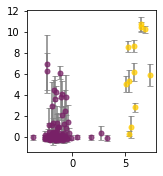

In [138]:
#on target vs off target 
on_targets = "#ffcc00ff"
off_targets = "#782167ff"
f, ax = plt.subplots(figsize=(2.5, 2.5))
plt.errorbar(x = compare[compare.on_target == False]['log_fa'],
             y = compare[compare.on_target == False]['ashr_log2FoldChange_HIS_TRP_10mM'], 
             yerr= compare[compare.on_target == False]['ashr_lfcSE_HIS_TRP_10mM'], 
             fmt="o", elinewidth = 2, alpha = 0.75, color = off_targets, capsize = 3, markersize = 5, ecolor = 'gray')
plt.errorbar(x = compare[compare.on_target == True]['log_fa'],
             y = compare[compare.on_target == True]['ashr_log2FoldChange_HIS_TRP_10mM'], 
             yerr= compare[compare.on_target == True]['ashr_lfcSE_HIS_TRP_10mM'], 
             fmt="o", elinewidth = 2, alpha = 0.75, color = on_targets, capsize = 3, markersize = 5, ecolor = 'gray')#plt.xlabel('Log2 fold change')
#plt.ylabel('Log fold activation')
plt.tight_layout()
plt.savefig('./figures/' + 'ashr_v_log_fa_10.svg', dpi = 300)
plt.show()

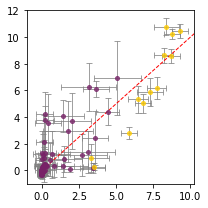

In [166]:
#on target vs off target 
on_targets = "#ffcc00ff"
off_targets = "#782167ff"
f, ax = plt.subplots(figsize=(3, 3))
plt.errorbar(x = compare[compare.on_target == False]['ashr_log2FoldChange_HIS_TRP_2mM'],
             y = compare[compare.on_target == False]['ashr_log2FoldChange_HIS_TRP_10mM'], 
             yerr= compare[compare.on_target == False]['ashr_lfcSE_HIS_TRP_10mM'], 
             xerr= compare[compare.on_target == False]['ashr_lfcSE_HIS_TRP_2mM'], 
             fmt="o", elinewidth = 1, alpha = 0.75, color = off_targets, capsize = 3, markersize = 4, ecolor = 'gray')
plt.errorbar(x = compare[compare.on_target == True]['ashr_log2FoldChange_HIS_TRP_2mM'],
             y = compare[compare.on_target == True]['ashr_log2FoldChange_HIS_TRP_10mM'], 
             yerr= compare[compare.on_target == True]['ashr_lfcSE_HIS_TRP_10mM'], 
             xerr= compare[compare.on_target == True]['ashr_lfcSE_HIS_TRP_2mM'], 
             fmt="o", elinewidth = 1, alpha = 0.75, color = on_targets, capsize = 3, markersize = 4, ecolor = 'gray')#plt.xlabel('Log2 fold change')
#plt.ylabel('Log fold activation')
plt.plot([0,12.5],[0,12.5], linestyle = '--', color = 'red', lw = 1)
#plt.xlim([0,12.25], [0,12.25])
plt.xlim([-1,10.25])#, [0,12.25])
plt.ylim([-1,12])
plt.tight_layout()
plt.savefig('./figures/' + 'ashr_v_log_fa_10_2.svg', dpi = 300)
plt.savefig('./figures/' + 'ashr_v_log_fa_10_2.png', dpi = 300)
plt.show()

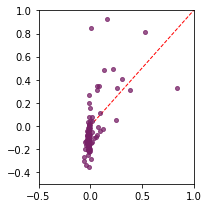

In [221]:
#on target vs off target 
on_targets = "#ffcc00ff"
off_targets = "#782167ff"
f, ax = plt.subplots(figsize=(3, 3))
plt.errorbar(x = compare[compare.on_target == False]['ashr_log2FoldChange_HIS_TRP_2mM'],
             y = compare[compare.on_target == False]['ashr_log2FoldChange_HIS_TRP_10mM'], 
             #yerr= compare[compare.on_target == False]['ashr_lfcSE_HIS_TRP_10mM'], 
             #xerr= compare[compare.on_target == False]['ashr_lfcSE_HIS_TRP_2mM'], 
             fmt="o", elinewidth = 1, alpha = 0.75, color = off_targets, capsize = 3, markersize = 4, ecolor = 'gray')
plt.errorbar(x = compare[compare.on_target == True]['ashr_log2FoldChange_HIS_TRP_2mM'],
             y = compare[compare.on_target == True]['ashr_log2FoldChange_HIS_TRP_10mM'], 
             #yerr= compare[compare.on_target == True]['ashr_lfcSE_HIS_TRP_10mM'], 
             #xerr= compare[compare.on_target == True]['ashr_lfcSE_HIS_TRP_2mM'], 
             fmt="o", elinewidth = 1, alpha = 0.75, color = on_targets, capsize = 3, markersize = 4, ecolor = 'gray')#plt.xlabel('Log2 fold change')
#plt.ylabel('Log fold activation')
plt.plot([0,12.5],[0,12.5], linestyle = '--', color = 'red', lw = 1)
#plt.xlim([0,12.25], [0,12.25])
plt.xlim([-0.5,1])#, [0,12.25])
plt.ylim([-0.5,1])
plt.tight_layout()
#plt.savefig('./figures/' + 'ashr_v_log_fa_10_2.svg', dpi = 300)
#plt.savefig('./figures/' + 'ashr_v_log_fa_10_2.png', dpi = 300)
plt.show()

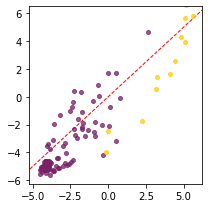

In [177]:
#on target vs off target 
on_targets = "#ffcc00ff"
off_targets = "#782167ff"
f, ax = plt.subplots(figsize=(3, 3))
plt.errorbar(x = compare[compare.on_target == False]['avg_log2_no_adj_counts_2mM'],
             y = compare[compare.on_target == False]['avg_log2_no_adj_counts_10mM'], 
             #yerr= compare[compare.on_target == False]['ashr_lfcSE_HIS_TRP_10mM'], 
             #xerr= compare[compare.on_target == False]['ashr_lfcSE_HIS_TRP_2mM'], 
             fmt="o", elinewidth = 1, alpha = 0.75, color = off_targets, capsize = 3, markersize = 4, ecolor = 'gray')
plt.errorbar(x = compare[compare.on_target == True]['avg_log2_no_adj_counts_2mM'],
             y = compare[compare.on_target == True]['avg_log2_no_adj_counts_10mM'], 
             #yerr= compare[compare.on_target == True]['ashr_lfcSE_HIS_TRP_10mM'], 
             #xerr= compare[compare.on_target == True]['ashr_lfcSE_HIS_TRP_2mM'], 
             fmt="o", elinewidth = 1, alpha = 0.75, color = on_targets, capsize = 3, markersize = 4, ecolor = 'gray')#plt.xlabel('Log2 fold change')
#plt.ylabel('Log fold activation')
plt.plot([-7,7],[-7,7], linestyle = '--', color = 'red', lw = 1)
plt.xlim([-5.25,6.2])
#plt.xlim([-1,10.25])#, [0,12.25])
plt.ylim([-6.25,6.5])
plt.tight_layout()
plt.savefig('./figures/' + 'ashr_v_log_fa_10_2_avg.svg', dpi = 300)
plt.savefig('./figures/' + 'ashr_v_log_fa_10_2_avg.png', dpi = 300)
plt.show()

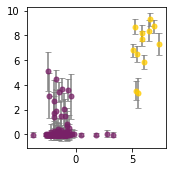

In [139]:
#on target vs off target 
on_targets = "#ffcc00ff"
off_targets = "#782167ff"
f, ax = plt.subplots(figsize=(2.5, 2.5))
plt.errorbar(x = compare[compare.on_target == False]['log_fa'],
             y = compare[compare.on_target == False]['ashr_log2FoldChange_HIS_TRP_2mM'], 
             yerr= compare[compare.on_target == False]['ashr_lfcSE_HIS_TRP_2mM'], 
             fmt="o", elinewidth = 2, alpha = 0.75, color = off_targets, capsize = 3, markersize = 5, ecolor = 'gray')
plt.errorbar(x = compare[compare.on_target == True]['log_fa'],
             y = compare[compare.on_target == True]['ashr_log2FoldChange_HIS_TRP_2mM'], 
             yerr= compare[compare.on_target == True]['ashr_lfcSE_HIS_TRP_2mM'], 
             fmt="o", elinewidth = 2, alpha = 0.75, color = on_targets, capsize = 3, markersize = 5, ecolor = 'gray')#plt.xlabel('Log2 fold change')
#plt.ylabel('Log fold activation')
plt.tight_layout()
plt.savefig('./figures/' + 'ashr_v_log_fa_2.svg', dpi = 300)
plt.show()

In [88]:
compare['ashr_log2FoldChange_HIS_TRP_10mM_mm']= (compare['ashr_log2FoldChange_HIS_TRP_10mM'] - compare['ashr_log2FoldChange_HIS_TRP_10mM'].min())/(compare['ashr_log2FoldChange_HIS_TRP_10mM'].max() - compare['ashr_log2FoldChange_HIS_TRP_10mM'].min())
compare['ashr_log2FoldChange_HIS_TRP_2mM_mm']= (compare['ashr_log2FoldChange_HIS_TRP_2mM'] - compare['ashr_log2FoldChange_HIS_TRP_2mM'].min())/(compare['ashr_log2FoldChange_HIS_TRP_2mM'].max() - compare['ashr_log2FoldChange_HIS_TRP_2mM'].min())

In [303]:
compare['diff_deseq2'] = compare['ashr_log2FoldChange_HIS_TRP_10mM'] - compare['ashr_log2FoldChange_HIS_TRP_2mM']
compare['diff_deseq2_log2'] = compare['avg_log2_no_adj_counts_10mM'] - compare['avg_log2_no_adj_counts_2mM']

compare['diff_deseq2_mm'] = compare['ashr_log2FoldChange_HIS_TRP_10mM_mm'] - compare['ashr_log2FoldChange_HIS_TRP_2mM_mm']
compare['diff_deseq2_adj'] = compare['diff_deseq2'] / compare['ashr_log2FoldChange_HIS_TRP_2mM']

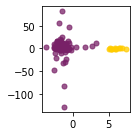

In [277]:
#on target vs off target 
on_targets = "#ffcc00ff"
off_targets = "#782167ff"
f, ax = plt.subplots(figsize=(2, 2))
plt.errorbar(x = compare[compare.on_target == False]['log_fa'],
             y = compare[compare.on_target == False]['diff_deseq2_adj'], 
             #yerr= compare[compare.on_target == False]['ashr_lfcSE_HIS_TRP_10mM'], 
             fmt="o", elinewidth = 2, alpha = 0.75, color = off_targets, capsize = 3, markersize = 5, ecolor = 'gray')
plt.errorbar(x = compare[compare.on_target == True]['log_fa'],
             y = compare[compare.on_target == True]['diff_deseq2_adj'], 
             #yerr= compare[compare.on_target == True]['ashr_lfcSE_HIS_TRP_10mM'], 
             fmt="o", elinewidth = 2, alpha = 0.75, color = on_targets, capsize = 3, markersize = 5, ecolor = 'gray')#plt.xlabel('Log2 fold change')
#plt.ylabel('Log fold activation')
plt.tight_layout()
#plt.savefig('./figures/' + 'ashr_v_log_fa.svg', dpi = 300)
plt.show()

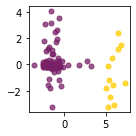

In [278]:
#on target vs off target 
on_targets = "#ffcc00ff"
off_targets = "#782167ff"
f, ax = plt.subplots(figsize=(2, 2))
plt.errorbar(x = compare[compare.on_target == False]['log_fa'],
             y = compare[compare.on_target == False]['diff_deseq2'], 
             #yerr= compare[compare.on_target == False]['ashr_lfcSE_HIS_TRP_10mM'], 
             fmt="o", elinewidth = 2, alpha = 0.75, color = off_targets, capsize = 3, markersize = 5, ecolor = 'gray')
plt.errorbar(x = compare[compare.on_target == True]['log_fa'],
             y = compare[compare.on_target == True]['diff_deseq2'], 
             #yerr= compare[compare.on_target == True]['ashr_lfcSE_HIS_TRP_10mM'], 
             fmt="o", elinewidth = 2, alpha = 0.75, color = on_targets, capsize = 3, markersize = 5, ecolor = 'gray')#plt.xlabel('Log2 fold change')
#plt.ylabel('Log fold activation')
plt.tight_layout()
#plt.savefig('./figures/' + 'ashr_v_log_fa.svg', dpi = 300)
plt.show()

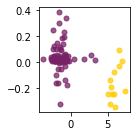

In [279]:
#on target vs off target 
on_targets = "#ffcc00ff"
off_targets = "#782167ff"
f, ax = plt.subplots(figsize=(2, 2))
plt.errorbar(x = compare[compare.on_target == False]['log_fa'],
             y = compare[compare.on_target == False]['diff_deseq2_mm'], 
             #yerr= compare[compare.on_target == False]['ashr_lfcSE_HIS_TRP_10mM'], 
             fmt="o", elinewidth = 2, alpha = 0.75, color = off_targets, capsize = 3, markersize = 5, ecolor = 'gray')
plt.errorbar(x = compare[compare.on_target == True]['log_fa'],
             y = compare[compare.on_target == True]['diff_deseq2_mm'], 
             #yerr= compare[compare.on_target == True]['ashr_lfcSE_HIS_TRP_10mM'], 
             fmt="o", elinewidth = 2, alpha = 0.75, color = on_targets, capsize = 3, markersize = 5, ecolor = 'gray')#plt.xlabel('Log2 fold change')
#plt.ylabel('Log fold activation')
plt.tight_layout()
#plt.savefig('./figures/' + 'ashr_v_log_fa.svg', dpi = 300)
plt.show()

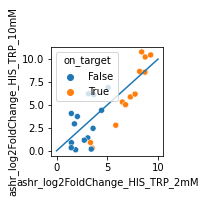

In [280]:
f, ax = plt.subplots(figsize=(2, 2))
sns.scatterplot(data = compare[compare.ashr_padj_HIS_TRP_2mM <= 0.1], x = 'ashr_log2FoldChange_HIS_TRP_2mM', y = 'ashr_log2FoldChange_HIS_TRP_10mM', hue = 'on_target')
plt.plot([0,10], [0,10])
plt.show()

(-1.0, 1.0)

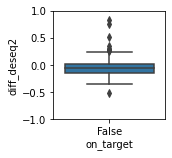

In [281]:
f, ax = plt.subplots(figsize=(2, 2))
sns.boxplot(data = compare[compare.ashr_padj_HIS_TRP_2mM > 0.1], y = 'diff_deseq2', x = 'on_target')
plt.ylim([-1,1])


<AxesSubplot:ylabel='diff_deseq2'>

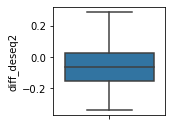

In [283]:
f, ax = plt.subplots(figsize=(2, 2))
sns.boxplot(data = compare, y = 'diff_deseq2',showfliers = False)



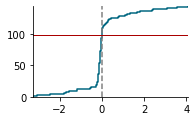

In [330]:
sns.displot(data = compare, x = 'diff_deseq2', kind = 'ecdf', stat = 'count',height=2 , aspect = 1.5, color= '#006680ff')#,showfliers = False)
plt.plot([0,0],[0,144], linestyle = '--', lw = 1.5, c = 'gray')
plt.plot([-4,4.5],[99,99], linestyle = '-', lw = 1, color = '#aa0000ff')
plt.xlabel('')
plt.ylabel('')
#plt.xlim(-5,5)

plt.xlim([-3.24,4.06])
plt.savefig('./figures/ecdf_diff_adj.svg')


In [331]:
compare.diff_deseq2_log2.max()

2.6651713290392256

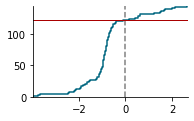

In [332]:
sns.displot(data = compare, x = 'diff_deseq2_log2', kind = 'ecdf', stat = 'count',height=2 , aspect = 1.5, color = '#006680ff')#,showfliers = False)
plt.plot([0,0],[0,144], linestyle = '--', lw = 1.5, c= 'gray')
plt.plot([-4,4.5],[122,122], linestyle = '-', lw = 1, c = '#aa0000ff')
plt.xlabel('')
plt.ylabel('')
#plt.xlim(-5,5)
plt.xlim([-3.96,2.67])
plt.savefig('./figures/ecdf_diff_adj_log2.svg')


In [ ]:
compare[compare['ashr_log2FoldChange_HIS_TRP_2mM'] > compare['ashr_log2FoldChange_HIS_TRP_10mM']].diff_deseq2#, 'diff_deseq2_mm']].sort_values('diff_deseq2_mm')

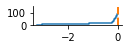

In [296]:
sns.displot(data = compare[compare['ashr_log2FoldChange_HIS_TRP_2mM'] > compare['ashr_log2FoldChange_HIS_TRP_10mM']], x = 'diff_deseq2', kind = 'ecdf', stat = 'count',height=1 , aspect = 2)#,showfliers = False)
plt.plot([0,0],[0,144], linestyle = '--', lw = 2)
plt.xlabel('')
plt.ylabel('')
#plt.xlim(-5,5)
plt.savefig('./figures/ecdf_diff_adj.svg')


In [305]:
compare[compare['avg_log2_no_adj_counts_2mM'] > compare['avg_log2_no_adj_counts_10mM']].diff_deseq2#, 'diff_deseq2_mm']].sort_values('diff_deseq2_mm')

2     -0.046289
3     -0.083046
4     -0.041090
5     -0.155185
6     -1.771756
         ...   
139   -0.095867
140   -0.157476
141   -1.577050
142   -1.556549
143   -0.013979
Name: diff_deseq2, Length: 122, dtype: float64

In [294]:
compare[['PPI','ashr_log2FoldChange_HIS_TRP_2mM','ashr_log2FoldChange_HIS_TRP_10mM', 'diff_deseq2_mm']].sort_values('diff_deseq2_mm')

,PPI,ashr_log2FoldChange_HIS_TRP_2mM,ashr_log2FoldChange_HIS_TRP_10mM,diff_deseq2_mm
131,DBD:Jerala_P11:AD:Jerala_P12,5.838431,2.786566,-0.349544
79,DBD:Jerala_P7:AD:Jerala_P8,3.515893,0.276204,-0.326272
130,DBD:Jerala_P11:AD:Jerala_P11,3.420064,0.184629,-0.324233
64,DBD:Jerala_P6:AD:Jerala_P5,3.343438,0.902530,-0.251543
90,DBD:Jerala_P8:AD:Jerala_P7,6.798557,5.026400,-0.251194
...,...,...,...,...
39,DBD:Jerala_P4:AD:Jerala_P4,1.456407,4.068089,0.234904
124,DBD:Jerala_P11:AD:Jerala_P5,3.142199,6.223179,0.247919
82,DBD:Jerala_P7:AD:Jerala_P11,0.414895,3.575402,0.302201
113,DBD:Jerala_P10:AD:Jerala_P6,0.205547,3.758015,0.341026


In [257]:
compare[compare.diff_deseq2_adj > 0].shape

(45, 35)

<AxesSubplot:xlabel='on_target', ylabel='diff_deseq2_adj'>

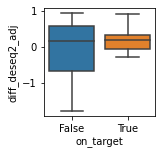

In [228]:
f, ax = plt.subplots(figsize=(2, 2))
sns.boxplot(data = compare[compare.ashr_padj_HIS_TRP_2mM <= 0.1], y = 'diff_deseq2_adj', x = 'on_target')
#plt.ylim([-2,2])


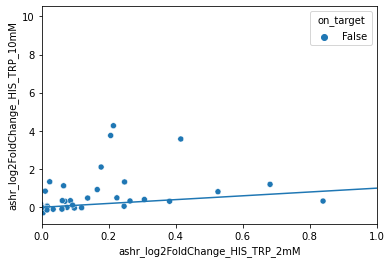

In [230]:
fig = plt.figure()
sns.scatterplot(data = compare[compare.ashr_padj_HIS_TRP_2mM > 0.1], x = 'ashr_log2FoldChange_HIS_TRP_2mM', y = 'ashr_log2FoldChange_HIS_TRP_10mM', hue = 'on_target')
plt.plot([0,10], [0,10])
plt.xlim([0,1])
plt.show()

(-2.0, 2.0)

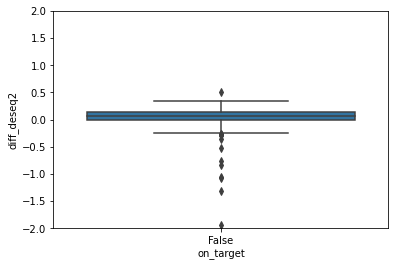

In [231]:
sns.boxplot(data = compare[compare.ashr_padj_HIS_TRP_2mM > 0.1], y = 'diff_deseq2', x = 'on_target')
plt.ylim([-2,2])

<AxesSubplot:xlabel='on_target', ylabel='diff_deseq2'>

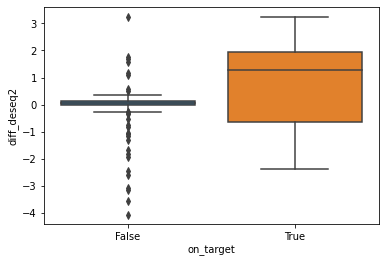

In [232]:
sns.boxplot(data = compare, y = 'diff_deseq2', x = 'on_target')


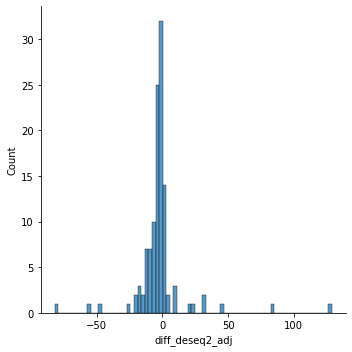

In [233]:
sns.displot(compare[compare.ashr_padj_HIS_TRP_2mM > 0.1].diff_deseq2_adj)

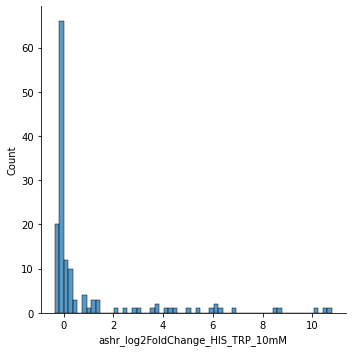

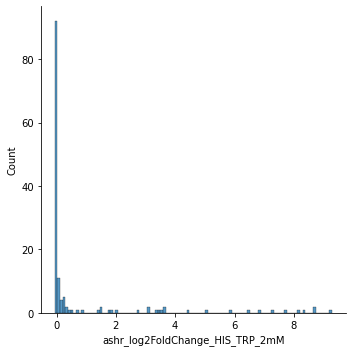

In [235]:
sns.displot(compare.ashr_log2FoldChange_HIS_TRP_10mM, )
sns.displot(compare.ashr_log2FoldChange_HIS_TRP_2mM,)

[Text(-10.0, 0, '−10'), Text(-5.0, 0, '−5'), Text(0.0, 0, '0'), Text(5.0, 0, '5'), Text(10.0, 0, '10'), Text(5.0, 0, '5.0'), Text(7.5, 0, '7.5'), Text(0, 0, ''), Text(0, 0, '')]
[Text(0, 0.0, '0.00'), Text(0, 0.25, '0.25'), Text(0, 0.5, '0.50'), Text(0, 0.75, '0.75'), Text(0, 1.0, '1.00')]


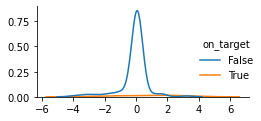

In [236]:
sns.displot( data = compare, x = 'diff_deseq2', hue="on_target", kind="kde",height=2 , aspect = 1.5)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.tight_layout()
ax.set_xlim(left = 0)
ax.set_ylim(bottom = 0)
locsx, labels = plt.xticks()
print (labels)
#plt.xticks([0,0.01,0.02], [])
locsy, labels = plt.yticks()
print (labels)
#plt.yticks([0,0.01,0.02], [])
plt.xlabel("")
plt.ylabel("")
#resize 
plt.savefig('./figures/' 'dist_10_2.svg', dpi = 300)

plt.show()

[Text(-10.0, 0, '−10'), Text(-5.0, 0, '−5'), Text(0.0, 0, '0'), Text(5.0, 0, '5'), Text(2.5, 0, '2.5')]
[Text(0, 0.0, '0'), Text(0, 1.0, '1'), Text(0, 2.0, '2')]


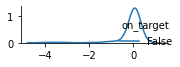

In [237]:
sns.displot( data = compare[compare.ashr_padj_HIS_TRP_2mM > 0.1], x = 'diff_deseq2', hue="on_target", kind="kde",height=1.25 , aspect = 1.5)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.tight_layout()
ax.set_xlim(left = 0)
ax.set_ylim(bottom = 0)
locsx, labels = plt.xticks()
print (labels)
#plt.xticks([0,0.01,0.02], [])
locsy, labels = plt.yticks()
print (labels)
#plt.yticks([0,0.01,0.02], [])
plt.xlabel("")
plt.ylabel("")
#resize 
plt.savefig('./figures/' 'dist_10_2_padj_not_sig.svg', dpi = 300)

#plt.savefig('./figures/' 'fraction_change_2mm.svg', dpi = 300)

plt.show()

In [238]:
compare[compare.ashr_padj_HIS_TRP_2mM > 0.1].diff_deseq2.mean()

-0.09857779775888852

In [239]:
compare.diff_deseq2.mean()

-0.028332148951847533

[Text(-10.0, 0, '−10'), Text(-5.0, 0, '−5'), Text(0.0, 0, '0'), Text(5.0, 0, '5'), Text(10.0, 0, '10')]
[Text(0, 0.0, '0.00'), Text(0, 0.05, '0.05'), Text(0, 0.1, '0.10')]


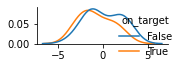

In [197]:
sns.displot( data = compare[compare.ashr_padj_HIS_TRP_2mM <= 0.1], x = 'diff_deseq2', hue="on_target", kind="kde",height=1.25 , aspect = 1.5)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.tight_layout()
ax.set_xlim(left = 0)
ax.set_ylim(bottom = 0)
locsx, labels = plt.xticks()
print (labels)
#plt.xticks([0,0.01,0.02], [])
locsy, labels = plt.yticks()
print (labels)
#plt.yticks([0,0.01,0.02], [])
plt.xlabel("")
plt.ylabel("")
#resize 
plt.savefig('./figures/' 'dist_10_2_padj_sig.svg', dpi = 300)

#plt.savefig('./figures/' 'dist_10_2.svg', dpi = 300)

#plt.savefig('./figures/' 'fraction_change_2mm.svg', dpi = 300)

plt.show()

[Text(-10.0, 0, '−10'), Text(-5.0, 0, '−5'), Text(0.0, 0, '0'), Text(5.0, 0, '5'), Text(10.0, 0, '10')]
[Text(0, 0.0, '0.0'), Text(0, 0.1, '0.1'), Text(0, 0.2, '0.2')]


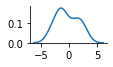

In [ ]:
sns.displot( data = compare, x = 'diff_deseq2', hue="on_target", kind="kde",height=1.25 , aspect = 1.5)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.tight_layout()
ax.set_xlim(left = 0)
ax.set_ylim(bottom = 0)
locsx, labels = plt.xticks()
print (labels)
#plt.xticks([0,0.01,0.02], [])
locsy, labels = plt.yticks()
print (labels)
#plt.yticks([0,0.01,0.02], [])
plt.xlabel("")
plt.ylabel("")
#resize 
#plt.savefig('./figures/' 'fraction_change_2mm.svg', dpi = 300)

plt.show()